In [1]:
import os
import pandas as pd
import numpy as np
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import default_style

# This is for reloading custom modules in case they are modified
%load_ext autoreload
%autoreload 2

font sizes set


In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

df = pd.read_csv(DATASET)
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,1st,actor_1,M
1,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
3,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
4,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [3]:
TARGET_COLUMN = 'vocal_channel'
values = df[TARGET_COLUMN].unique().tolist()
values

['speech', 'song']

# Dataset preparation

In [4]:
try:
    excluded_prefixes = ['zc']
    columns_to_remove = []
    for column in df[numerical_attr_list].columns:
        if column.startswith(tuple(excluded_prefixes)) or column == TARGET_COLUMN:
            columns_to_remove.append(column)

    columns_to_remove;
    df = df.drop(columns=columns_to_remove, axis=1)
    
except KeyError as e:
    print(e)
    
for col in columns_to_remove:
    try:
        print(col)
        numerical_attr_list.remove(col)
    except ValueError as e:
        print(e, f"raised by column '{col}'")
        

zc_sum
zc_mean
zc_std
zc_kur
zc_skew
zc_kur_w1
zc_sum_w2
zc_std_w2
zc_sum_w3
zc_kur_w3
zc_sum_w4
zc_skew_w4


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
scaler = MinMaxScaler()
X = scaler.fit_transform(df[numerical_attr_list])

label_enc = LabelEncoder()
y = label_enc.fit_transform(df[TARGET_COLUMN])

# print(f"numerical_attr_list is {numerical_attr_list}")
print(f"target variable: {np.unique(y, return_counts=True)}")
print(f"X has shape {X.shape}")

target variable: (array([0, 1]), array([1003, 1426]))
X has shape (2429, 231)


In [6]:
from sklearn.model_selection import train_test_split

# Divide in train, test, validation
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
test_mask = df.actor_number >= 19
df.drop(columns="actor_number", inplace=True)

X_test, y_test = X[test_mask], y[test_mask]

X_train, X_val, y_train, y_val = train_test_split(X[~test_mask], y[~test_mask], test_size=0.2)
print(f"Train: {X_train.shape}\nVal: {X_val.shape}\nTest: {X_test.shape}")

Train: (1449, 231)
Val: (363, 231)
Test: (617, 231)


### Default plots

In [7]:
# Shows the decision boundaries in the embedding
def boundaries_on_embedding(reducer, predictor, 
                            plot_function="predict", levels=None, linewidths=1.5,
                            embedding=None, n_pts=30,
                            ax=None, subsamp_fraction=0.5,
                            **kwargs):
    
    global X, y, X_train, X_test,X_val, y_train, y_test, y_val
    cmap, title = kwargs.get("cmap", "viridis"), kwargs.get("title", "Decision boundaries on embedding")
    
    edges_color = (0.2, 0.2, 0.2)
    edges_color_neg = (0.8, 0.8, 0.8)
    
    if embedding is None:
        embedding =  reducer.fit_transform(X)
        
    if ax is None:
        fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
        
    if levels is None:
        levels=len(np.unique(y))-1
        
    # Generate a grid in embedding
    xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), n_pts)
    yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), n_pts)

    XX, YY = np.meshgrid(xx, yy)
    points_in_embedding = np.array(np.meshgrid(xx, yy)).T
    old_shape = points_in_embedding.shape[:-1]
    
    # Maps them back in the big space
    points_in_embedding = points_in_embedding.reshape(-1,2)
    points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

    # Gets results
    plotting_function = getattr(predictor, plot_function)
    results = plotting_function(points_in_gigaspace).reshape(old_shape)
    plt.contourf(XX, YY, results.T, cmap=cmap, alpha=0.6, levels=levels)
    
    
    # Plots the scatter
    subsamp = np.random.uniform(0,1, size=len(test_mask)) < subsamp_fraction
    plt.scatter(*embedding[(~test_mask)&(subsamp)].T, c=y[(~test_mask)&(subsamp)], 
                marker="o", 
                edgecolor=None,  
                s=7, 
                cmap=cmap,
                alpha=1,
                label="train+val")
    plt.scatter(*embedding[test_mask&subsamp].T, c=y[(test_mask)&(subsamp)], 
                marker="o", 
                edgecolor=edges_color, 
                s=7,
                cmap=cmap,
                alpha=1,
                label="test")
    
    # Plot contours without color
    plt.contour(XX, YY, results.T, alpha=1, 
                levels=levels, 
                colors=[edges_color, edges_color_neg],
                   linewidths=linewidths)

    plt.legend()
    plt.axis("off");
    plt.title(title);
    plt.savefig(f"images/{title.replace(' ', '_')}.pdf")

In [8]:
from sklearn.metrics import confusion_matrix

def plot_cfm(y_true, y_pred, title="Confusion matrix", cmap="Greens"):
    fig, ax = plt.subplots(figsize=default_style.SHORT_HALFSIZE_FIGURE)
    cf = confusion_matrix(y_true, y_pred)
    sns.heatmap(cf, annot=True, cmap=cmap, fmt=".4g", cbar=False, ax=ax, vmin=0)
    ax.set_xlabel('True')
    ax.set_ylabel('Predicted')
    ax.set_title(title)

    ticks = np.unique(y_true)
    ax.set_xticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    ax.set_yticks(ticks + 0.5, labels=label_enc.inverse_transform(ticks))
    ax.set_aspect("equal")
    plt.savefig(f"images/{title.replace(' ', '_')}.pdf")

### Select and embedding

In [9]:
from sklearn.decomposition import PCA

reducer = PCA(n_components=2)
embedding = reducer.fit_transform(X)
embedding_name = "PCA"
# from umap import UMAP

# reducer = UMAP(n_neighbors=20)
# embedding = reducer.fit_transform(X)
# embedding_name = "UMAP"

In [10]:
# Some properties
N_PTS = 80
CMAP = "Spectral"
CMAP_CFM = "RdGy_r"

# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import optuna
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import optuna

# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['none', 'elasticnet', 'l1', 'l2'])
    C = trial.suggest_float('C', 0.001,10)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg',  'sag', 'saga'])

    logr = LogisticRegression(solver=solver, penalty=penalty, C=C)

    logr.fit(X_train, y_train)
    y_pred = logr.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError, TypeError))

[I 2023-07-10 15:17:45,495] A new study created in memory with name: no-name-bd4e3bc8-c278-41a2-bf24-29bab6f75dc7
[W 2023-07-10 15:17:45,509] Trial 1 failed with parameters: {'penalty': 'none', 'C': 9.121415228136696, 'solver': 'liblinear'} because of the following error: ValueError("penalty='none' is not supported for the liblinear solver").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 71, in

[W 2023-07-10 15:17:46,132] Trial 12 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2023-07-10 15:17:46,376] Trial 9 finished with value: 0.9862258953168044 and parameters: {'penalty': 'l2', 'C': 3.7491780837565662, 'solver': 'lbfgs'}. Best is trial 6 with value: 0.9862258953168044.
[I 2023-07-10 15:17:46,892] Trial 14 finished with value: 0.9834710743801653 and parameters: {'penalty': 'l2', 'C': 1.453916872268936, 'solver': 'newton-cg'}. Best is trial 6 with valu

[W 2023-07-10 15:17:48,121] Trial 24 failed with value None.
[W 2023-07-10 15:17:48,130] Trial 25 failed with parameters: {'penalty': 'elasticnet', 'C': 9.49710296182102, 'solver': 'newton-cg'} because of the following error: ValueError("Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    rais

[W 2023-07-10 15:17:49,391] Trial 31 failed with value None.
[W 2023-07-10 15:17:49,417] Trial 32 failed with parameters: {'penalty': 'elasticnet', 'C': 5.268392963658086, 'solver': 'saga'} because of the following error: TypeError("unsupported operand type(s) for -: 'int' and 'NoneType'").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(ite

[W 2023-07-10 15:17:50,208] Trial 38 failed with value None.
[W 2023-07-10 15:17:50,244] Trial 39 failed with parameters: {'penalty': 'elasticnet', 'C': 4.927572682242752, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueErr

[W 2023-07-10 15:17:50,593] Trial 47 failed with parameters: {'penalty': 'elasticnet', 'C': 5.166096341669796, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueError(
ValueError: Only 'saga' solver supports elasticnet penalt

[W 2023-07-10 15:17:50,860] Trial 54 failed with value None.
[W 2023-07-10 15:17:50,877] Trial 55 failed with parameters: {'penalty': 'elasticnet', 'C': 2.211449589439093, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueErr

[W 2023-07-10 15:17:51,197] Trial 62 failed with value None.
[W 2023-07-10 15:17:51,211] Trial 63 failed with parameters: {'penalty': 'elasticnet', 'C': 1.9520908882311083, 'solver': 'liblinear'} because of the following error: ValueError("Only 'saga' solver supports elasticnet penalty, got solver=liblinear.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 64, in _check_solver
    raise ValueEr

[W 2023-07-10 15:17:51,471] Trial 71 failed with parameters: {'penalty': 'elasticnet', 'C': 2.0113920266383474, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' penal

[W 2023-07-10 15:17:51,670] Trial 79 failed with parameters: {'penalty': 'elasticnet', 'C': 2.01832435684485, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' penalti

[W 2023-07-10 15:17:51,842] Trial 84 failed with value None.
[W 2023-07-10 15:17:51,844] Trial 85 failed with value None.
[W 2023-07-10 15:17:51,846] Trial 83 failed with value None.
[W 2023-07-10 15:17:51,849] Trial 86 failed with value None.
[W 2023-07-10 15:17:51,877] Trial 87 failed with parameters: {'penalty': 'elasticnet', 'C': 2.0986803706973007, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalt

[W 2023-07-10 15:17:52,067] Trial 95 failed with parameters: {'penalty': 'elasticnet', 'C': 1.9274690705739723, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' penal

[W 2023-07-10 15:17:52,275] Trial 101 failed with value None.
[W 2023-07-10 15:17:52,286] Trial 103 failed with parameters: {'penalty': 'elasticnet', 'C': 2.1502360013615003, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueE

[W 2023-07-10 15:17:52,445] Trial 108 failed with value None.
[W 2023-07-10 15:17:52,446] Trial 110 failed with value None.
[W 2023-07-10 15:17:52,465] Trial 109 failed with value None.
[W 2023-07-10 15:17:52,470] Trial 111 failed with parameters: {'penalty': 'elasticnet', 'C': 1.785247780025386, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualen

[W 2023-07-10 15:17:52,644] Trial 115 failed with value None.
[W 2023-07-10 15:17:52,666] Trial 119 failed with parameters: {'penalty': 'elasticnet', 'C': 2.161527522523342, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueEr

[W 2023-07-10 15:17:52,847] Trial 125 failed with value None.
[W 2023-07-10 15:17:52,879] Trial 126 failed with value None.
[W 2023-07-10 15:17:52,889] Trial 127 failed with parameters: {'penalty': 'elasticnet', 'C': 2.1083226729395896, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_m

[W 2023-07-10 15:17:53,192] Trial 136 failed with parameters: {'penalty': 'elasticnet', 'C': 4.260123302930238, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solver sag supports only 'l2' or 'none' penal

[W 2023-07-10 15:17:53,342] Trial 141 failed with value None.
[W 2023-07-10 15:17:53,371] Trial 142 failed with value None.
[W 2023-07-10 15:17:53,375] Trial 143 failed with parameters: {'penalty': 'elasticnet', 'C': 1.6409521927659085, 'solver': 'sag'} because of the following error: ValueError("Solver sag supports only 'l2' or 'none' penalties, got elasticnet penalty.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/544188978.py", line 13, in objective_fun
    logr.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/linear_m

In [13]:
best_params = study.best_params
logr = LogisticRegression(**best_params)

# Trains on test AND validation
logr.fit(np.concatenate((X_train, X_val)), np.concatenate([y_train, y_val]))

y_pred_test = logr.predict(X_test)

from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 3.89527531892312, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       262
           1       1.00      0.92      0.96       355

    accuracy                           0.95       617
   macro avg       0.95      0.96      0.95       617
weighted avg       0.96      0.95      0.95       617

Accuracy 0.9546191247974068
F1-score [0.94909091 0.95906433]


choose liblinear solver beacause for small datasets is a good choice. 
The key difference between these l1(ridege) and l2(lasso) is that Lasso shrinks the less 
important feature’s coefficient to zero thus, removing some feature altogether. 
So, this works well for feature selection in case we have a huge number of features.

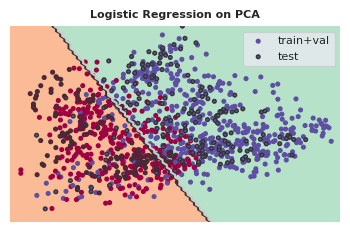

In [14]:
boundaries_on_embedding(reducer, logr, embedding=embedding, 
                        title=f"Logistic Regression on {embedding_name}", 
                        cmap="Spectral",
                        n_pts=N_PTS)

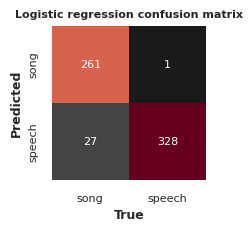

In [15]:
plot_cfm(y_test, y_pred_test, title="Logistic regression confusion matrix", cmap=CMAP_CFM)

# Support Vector Machine

## Linear SVM

In [16]:
from sklearn.svm import LinearSVC

In [17]:
# objective function to be minimized
def objective_fun(trial):

    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.01,100)
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    
    lin_svc = LinearSVC(loss=loss, penalty=penalty, C=C)

    lin_svc.fit(X_train, y_train)
    
    y_pred = lin_svc.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 150, n_jobs = -1, catch=(ValueError,))

[I 2023-07-10 15:17:57,468] A new study created in memory with name: no-name-6ce52a69-8fe5-4800-863f-d04944a81d44
[W 2023-07-10 15:17:57,487] Trial 0 failed with parameters: {'penalty': 'l1', 'C': 63.660678723827836, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pyt

[W 2023-07-10 15:17:57,574] Trial 8 failed with value None.
[W 2023-07-10 15:17:57,574] Trial 7 failed with parameters: {'penalty': 'l1', 'C': 52.35663053915232, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223,

[W 2023-07-10 15:17:57,986] Trial 15 failed with value None.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-10 15:17:58,256] Trial 13 finished with value: 0.9696969696969697 and parameters: {'penalty': 'l2', 'C': 5.833831468575478, 'loss': 'squared_hinge'}. Best is trial 13 with value: 0.9696969696969697.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2023-07-10 15:17:58,300] Trial 14 finished with value: 0.9669421487603306 and parameters: {'penalty': 'l2', 'C': 9.821572312533435, 'loss': 'squared_hinge'}. Best is trial 13 with value: 0.9696969696969697.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.

[W 2023-07-10 15:17:58,997] Trial 25 failed with value None.
[W 2023-07-10 15:17:59,043] Trial 26 failed with parameters: {'penalty': 'l1', 'C': 95.66278652835697, 'loss': 'hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 122

[W 2023-07-10 15:17:59,240] Trial 31 failed with value None.
[I 2023-07-10 15:17:59,243] Trial 18 finished with value: 0.9696969696969697 and parameters: {'penalty': 'l2', 'C': 90.02378576478624, 'loss': 'hinge'}. Best is trial 13 with value: 0.9696969696969697.
[W 2023-07-10 15:17:59,257] Trial 32 failed with parameters: {'penalty': 'l1', 'C': 20.565575217359275, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pyth

[W 2023-07-10 15:18:00,076] Trial 39 failed with value None.
[W 2023-07-10 15:18:00,086] Trial 40 failed with parameters: {'penalty': 'l1', 'C': 65.05616686023465, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-

[W 2023-07-10 15:18:00,321] Trial 47 failed with parameters: {'penalty': 'l1', 'C': 48.25147021688299, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear


[W 2023-07-10 15:18:00,452] Trial 52 failed with value None.
[W 2023-07-10 15:18:00,456] Trial 50 failed with parameters: {'penalty': 'l1', 'C': 3.3070449458930145, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-10 15:18:00,556] Trial 55 failed with value None.
[W 2023-07-10 15:18:00,557] Trial 57 failed with parameters: {'penalty': 'l1', 'C': 47.48995270385015, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-

[W 2023-07-10 15:18:00,697] Trial 65 failed with parameters: {'penalty': 'l1', 'C': 53.04823418187273, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear


[W 2023-07-10 15:18:00,798] Trial 69 failed with parameters: {'penalty': 'l1', 'C': 2.0821176301566027, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear

[W 2023-07-10 15:18:00,940] Trial 76 failed with parameters: {'penalty': 'l1', 'C': 51.36502692927676, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear


[W 2023-07-10 15:18:01,047] Trial 80 failed with value None.
[W 2023-07-10 15:18:01,048] Trial 82 failed with parameters: {'penalty': 'l1', 'C': 1.655933781535146, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-

[W 2023-07-10 15:18:01,167] Trial 86 failed with value None.
[W 2023-07-10 15:18:01,173] Trial 88 failed with parameters: {'penalty': 'l1', 'C': 3.0909436069737017, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site

[W 2023-07-10 15:18:01,268] Trial 91 failed with value None.
[W 2023-07-10 15:18:01,324] Trial 93 failed with value None.
[W 2023-07-10 15:18:01,327] Trial 94 failed with parameters: {'penalty': 'l1', 'C': 48.5205837682585, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanlo

[W 2023-07-10 15:18:01,427] Trial 97 failed with value None.
[W 2023-07-10 15:18:01,465] Trial 99 failed with value None.
[W 2023-07-10 15:18:01,469] Trial 100 failed with parameters: {'penalty': 'l1', 'C': 1.704531631263798, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djan

[W 2023-07-10 15:18:01,568] Trial 104 failed with value None.
[W 2023-07-10 15:18:01,569] Trial 106 failed with parameters: {'penalty': 'l1', 'C': 0.49309692536503036, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/s

[W 2023-07-10 15:18:01,702] Trial 111 failed with value None.
[W 2023-07-10 15:18:01,662] Trial 109 failed with value None.
[W 2023-07-10 15:18:01,757] Trial 112 failed with parameters: {'penalty': 'l1', 'C': 2.3603958901009965, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/d

[W 2023-07-10 15:18:01,916] Trial 119 failed with parameters: {'penalty': 'l1', 'C': 3.2979005271222235, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinea

[W 2023-07-10 15:18:02,021] Trial 121 failed with value None.
[W 2023-07-10 15:18:02,027] Trial 124 failed with parameters: {'penalty': 'l1', 'C': 1.6669785916042077, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/si

[W 2023-07-10 15:18:02,165] Trial 128 failed with value None.
[W 2023-07-10 15:18:02,167] Trial 130 failed with parameters: {'penalty': 'l1', 'C': 51.46526984015783, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[W 2023-07-10 15:18:02,317] Trial 136 failed with parameters: {'penalty': 'l1', 'C': 1.50473162762525, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear


[W 2023-07-10 15:18:02,432] Trial 139 failed with value None.
[W 2023-07-10 15:18:02,433] Trial 142 failed with parameters: {'penalty': 'l1', 'C': 48.56701647484752, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/sit

[W 2023-07-10 15:18:02,566] Trial 148 failed with parameters: {'penalty': 'l1', 'C': 2.329579337733321, 'loss': 'squared_hinge'} because of the following error: ValueError("Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/266359131.py", line 10, in objective_fun
    lin_svc.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 274, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear

In [18]:
best_params = study.best_params

lin_svc = LinearSVC(**best_params)
lin_svc.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = lin_svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'penalty': 'l2', 'C': 5.833831468575478, 'loss': 'squared_hinge'}
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       262
           1       0.99      0.94      0.97       355

    accuracy                           0.96       617
   macro avg       0.96      0.97      0.96       617
weighted avg       0.96      0.96      0.96       617

Accuracy 0.9611021069692058
F1-score [0.95588235 0.96521739]


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


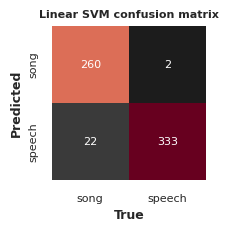

In [19]:
plot_cfm(y_test, y_pred_test, title="Linear SVM confusion matrix", cmap=CMAP_CFM)

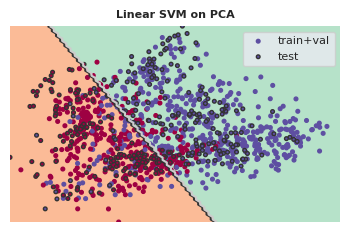

In [20]:
boundaries_on_embedding(reducer, lin_svc, embedding=embedding, 
                        title=f"Linear SVM on {embedding_name}", 
                        cmap=CMAP,
                       n_pts=N_PTS)

In [21]:
# decision_function = lin_svc.decision_function(X_train)
# support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
# support_vectors = X_train[support_vector_indices]

In [22]:
# # Plots the decision function for diferent values of C
# for i, C in enumerate([0.02, 300]):
#     plt.figure(figsize=default_style.SHORT_HALFSIZE_FIGURE)

#     cmap="viridis"
#     clf = LinearSVC(C=C, loss="hinge", penalty='l2', random_state=42).fit(X_test, y_test)

#     # Genearate a grid in embedding
#     xx = np.linspace(np.min(embedding[:,0]), np.max(embedding[:,0]), 30)
#     yy = np.linspace(np.min(embedding[:,1]), np.max(embedding[:,1]), 30)

#     XX, YY = np.meshgrid(xx, yy)
#     points_in_embedding = np.array(np.meshgrid(xx, yy)).T
#     old_shape = points_in_embedding.shape[:-1]
    
#     # Maps them back in the big space
#     points_in_embedding = points_in_embedding.reshape(-1,2)
#     points_in_gigaspace = reducer.inverse_transform(points_in_embedding)

#     # Gets results
#     results = clf.decision_function(points_in_gigaspace)
#     mappable=plt.contourf(XX, YY, results.reshape(old_shape).T, cmap="viridis", alpha=0.6, levels=15)
#     plt.scatter(*embedding[test_mask].T, c=y_test, marker="o", edgecolor="k", s=5,cmap=cmap, label="test")
#     plt.scatter(*embedding[~test_mask].T, c=y[~test_mask], marker="+",  s=5, cmap=cmap, label="train+val")
    
#     # Plot support
#     results = clf.decision_function(X_train)
#     support_vector_indices = np.where((2 * y_train - 1) * results <= 1)[0]
#     plt.scatter(*(embedding[~test_mask][support_vector_indices]).T, s=10, color="r")
#     plt.axis("off")
# #     decision_function = clf.decision_function(X_res_t)
# # #     we can also calculate the decision function manually
# # #     decision_function = np.dot(X_pca, clf.coef_[0]) + clf.intercept_[0]
# #     support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
# #     support_vectors = X_res_t[support_vector_indices]
# #     support_vectors_pca = pca.transform(support_vectors)

# #     plt.subplot(1, 2, i + 1)
# #     plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, s=30, cmap=plt.cm.Paired)
# #     ax = plt.gca()
# #     xlim = ax.get_xlim()
# #     ylim = ax.get_ylim()
# #     xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
# #                          np.linspace(ylim[0], ylim[1], 50))
# #     clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X_pca, y_res_t)
# #     Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# #     Z = Z.reshape(xx.shape)
# #     plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
# #                 linestyles=['--', '-', '--'])
# #     plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], s=100,
# #                 linewidth=1, facecolors='none', edgecolors='k')
# #     plt.title("C=" + str(C))
# #     #plt.scatter(clf.coef_[:, 0] + clf.intercept_, clf.coef_[:, 1] + clf.intercept_)
# # plt.tight_layout()
# # plt.show()
#     plt.savefig(f"images/linear_svm_UMAP_decision_function_C_{C}.pdf")
#     plt.colorbar(mappable)

The goal for SVM is find hyperplane that maximizes the margin, furthermore C is the inverse of regularization strength therefore smaller value of C correspond a stronger regularization namely greater margin

## Nonlinear SVM

In [23]:
from sklearn.svm import SVC

In [24]:
# objective function to be minimized
def objective_fun(trial):

    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.1,80)
    gamma = trial.suggest_float('gamma', 0.001, 1)
    degree = trial.suggest_int('degree', 1, 15)
    

    svc = SVC(kernel=kernel, gamma=gamma, C=C)

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_val)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 250, n_jobs = -1, catch=(ValueError,))

[I 2023-07-10 15:18:06,249] A new study created in memory with name: no-name-7d64551a-75c4-4cd6-a98e-ded1cab36758
[I 2023-07-10 15:18:06,584] Trial 2 finished with value: 0.977961432506887 and parameters: {'kernel': 'poly', 'C': 13.447949073810182, 'gamma': 0.2927896587328943, 'degree': 10}. Best is trial 2 with value: 0.977961432506887.
[I 2023-07-10 15:18:06,711] Trial 0 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 26.055603265773662, 'gamma': 0.1758427449728797, 'degree': 8}. Best is trial 0 with value: 0.9889807162534435.
[I 2023-07-10 15:18:06,934] Trial 4 finished with value: 0.977961432506887 and parameters: {'kernel': 'poly', 'C': 59.802162012794305, 'gamma': 0.2188501390687243, 'degree': 7}. Best is trial 0 with value: 0.9889807162534435.
[I 2023-07-10 15:18:06,993] Trial 1 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 1.8005188014068978, 'gamma': 0.5581095794947237, 'degree': 6}. Best is trial 0 with value: 0.

[I 2023-07-10 15:18:12,460] Trial 32 finished with value: 0.5619834710743802 and parameters: {'kernel': 'sigmoid', 'C': 46.82216836885678, 'gamma': 0.21718118205069895, 'degree': 8}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:12,522] Trial 38 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 68.52728299996375, 'gamma': 0.06695753750960301, 'degree': 9}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:12,810] Trial 40 finished with value: 0.977961432506887 and parameters: {'kernel': 'poly', 'C': 74.47656617885902, 'gamma': 0.08177718073590032, 'degree': 14}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:12,834] Trial 41 finished with value: 0.977961432506887 and parameters: {'kernel': 'poly', 'C': 75.14601725208937, 'gamma': 0.16831321678421102, 'degree': 14}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:12,842] Trial 39 finished with value: 0.977961432506887 and pa

[I 2023-07-10 15:18:15,769] Trial 72 finished with value: 0.977961432506887 and parameters: {'kernel': 'poly', 'C': 68.17078618533438, 'gamma': 0.21791289535957048, 'degree': 14}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:15,966] Trial 73 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 74.5304829782245, 'gamma': 0.006283893351102909, 'degree': 9}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:16,015] Trial 74 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 73.95090811606124, 'gamma': 0.06774939058459001, 'degree': 14}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:16,082] Trial 75 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 73.99477389371994, 'gamma': 0.0696790288461834, 'degree': 12}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:16,083] Trial 76 finished with value: 0.9862258953168044 and param

[I 2023-07-10 15:18:19,980] Trial 109 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 75.41920565686448, 'gamma': 0.08035390960596514, 'degree': 10}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:20,006] Trial 108 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 59.519964773705574, 'gamma': 0.09407023443457546, 'degree': 13}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:20,041] Trial 110 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 59.44189010629645, 'gamma': 0.08282240750444073, 'degree': 10}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:20,191] Trial 111 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 75.36740091380918, 'gamma': 0.08741556655646902, 'degree': 10}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:20,284] Trial 112 finished with value: 0.9889807162534435 a

[I 2023-07-10 15:18:24,626] Trial 146 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 72.7863027552412, 'gamma': 0.15728656113093806, 'degree': 13}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:24,658] Trial 143 finished with value: 0.5619834710743802 and parameters: {'kernel': 'sigmoid', 'C': 73.71524567083688, 'gamma': 0.15075987272366603, 'degree': 8}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:24,798] Trial 147 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 74.982718381627, 'gamma': 0.16241661843459765, 'degree': 13}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:25,028] Trial 149 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 60.73303380444409, 'gamma': 0.08688923645720278, 'degree': 12}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:25,049] Trial 148 finished with value: 0.9917355371900827 an

[I 2023-07-10 15:18:28,171] Trial 180 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 79.98132285195155, 'gamma': 0.1171625748521021, 'degree': 12}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:28,284] Trial 182 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 64.67911192429119, 'gamma': 0.2703374878659996, 'degree': 14}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:28,304] Trial 181 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 72.8380255725121, 'gamma': 0.19475863938867863, 'degree': 14}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:28,327] Trial 183 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 72.95756318765015, 'gamma': 0.13473555102892135, 'degree': 14}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:28,564] Trial 184 finished with value: 0.9889807162534435 and p

[I 2023-07-10 15:18:33,878] Trial 218 finished with value: 0.9917355371900827 and parameters: {'kernel': 'rbf', 'C': 77.71394062837658, 'gamma': 0.1520606097583298, 'degree': 5}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:33,929] Trial 215 finished with value: 0.9862258953168044 and parameters: {'kernel': 'rbf', 'C': 62.13183336347916, 'gamma': 0.3816040770544018, 'degree': 12}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:34,002] Trial 217 finished with value: 0.9862258953168044 and parameters: {'kernel': 'rbf', 'C': 78.48820185479065, 'gamma': 0.3892695505660007, 'degree': 5}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:34,102] Trial 219 finished with value: 0.9889807162534435 and parameters: {'kernel': 'rbf', 'C': 77.80257412991297, 'gamma': 0.3574331578625475, 'degree': 13}. Best is trial 12 with value: 0.9917355371900827.
[I 2023-07-10 15:18:34,445] Trial 221 finished with value: 0.9889807162534435 and para

In [25]:
best_params = study.best_params

svc = SVC(**best_params)
svc.fit(np.concatenate((X_train, X_val)),np.concatenate((y_train, y_val)))

y_pred_test = svc.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)
print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'kernel': 'rbf', 'C': 78.88500627892904, 'gamma': 0.14533279349352102, 'degree': 6}
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       262
           1       1.00      0.94      0.97       355

    accuracy                           0.96       617
   macro avg       0.96      0.97      0.96       617
weighted avg       0.97      0.96      0.96       617

Accuracy 0.9627228525121556
F1-score [0.95779817 0.96661829]


In [26]:
print(svc.support_vectors_.shape)
print(X.shape)

(232, 231)
(2429, 231)


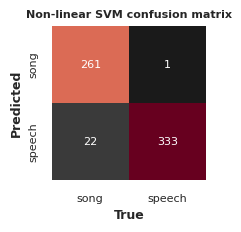

In [27]:
plot_cfm(y_test, y_pred_test, title="Non-linear SVM confusion matrix", cmap=CMAP_CFM)

In [28]:
# support_vectors_pca = pca.transform(svc.support_vectors_)

In [29]:
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res_t, 
#             cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=10)
# plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=10,
#                 linewidth=1, facecolors='none', edgecolors='k')
# plt.show()

In [30]:
# decision_function = svc.decision_function(X_res_t)
# support_vector_indices = np.where((2 * y_res_t - 1) * decision_function <= 1)[0]
# support_vectors = X_res_t[support_vector_indices]

In [31]:
# support_vectors_pca = pca.transform(support_vectors)

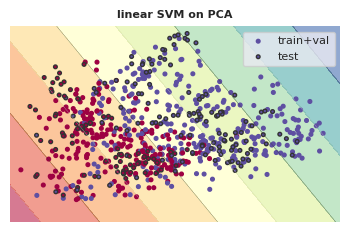

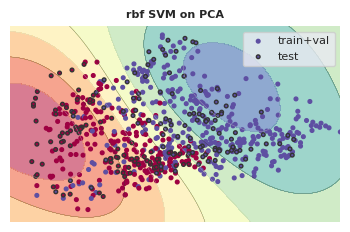

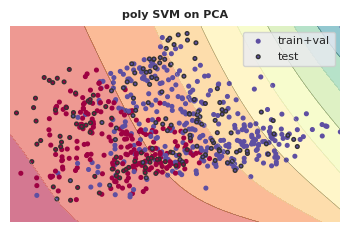

In [32]:
for kernel in ('linear', 'rbf', 'poly'):
    
    this_kernel_params = svc.get_params().copy()
    this_kernel_params["kernel"] = kernel
#     this_kernel_params["C"] = 0.5
    this_kernel_params["degree"] = 15
    
    clf = SVC(**this_kernel_params)
    clf.fit(X_train, y_train)
    
    boundaries_on_embedding(   reducer, clf, embedding=embedding,
                                title=f"{kernel} SVM on {embedding_name}",
                                plot_function="decision_function", levels=8, linewidths=0.2,
                                n_pts=100, subsamp_fraction=0.3,
                                cmap=CMAP
                           )
    

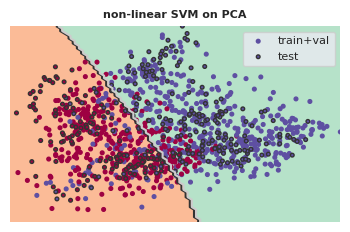

In [33]:
boundaries_on_embedding(reducer, svc, embedding=embedding, 
                        title=f"non-linear SVM on {embedding_name}", 
                        cmap=CMAP,
                        n_pts=N_PTS)
# plt.scatter(*(reducer.transform(svc.support_vectors_).T), color="r", s=10 , marker="+")

Show the different boundary for different kernel:
-Linear: just see previuos section
-Radial: Basis Function:The gamma parameters can be seen as the inverse of the radius of influence of   samples selected
-poly : the polynomial kernel looks not only at the given features of input samples to determine their similarity, but also combinations of these

# Neural Networks

In [34]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense

2023-07-10 15:18:55.863950: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 15:18:55.988581: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-10 15:18:55.993343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 15:18:58.471341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [35]:
from scikeras.wrappers import KerasClassifier

In [36]:
from sklearn.model_selection import RandomizedSearchCV

In [37]:
#  build the model for neural networks
def build_model(meta, hidden_layer_sizes, activation, optimizer):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation=activation))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, metrics=['accuracy'])
    return model

In [38]:
#Use Sklearn wrapper
clf = KerasClassifier(
    model = build_model,
    verbose = False
)

In [39]:
# objective function to be minimized
import random
import optuna
def objective_fun(trial):
    
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes',[(100, 100, 100), (50, 50, 50), (10, 10, 10), 
                                  (100, 50, 10), (10, 10, 10), (10, 10)])
#     learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': X.shape[1], 'n_classes_': len(np.unique(y))}                                      
                                          
    net = KerasClassifier(model=build_model(par, hidden_layer_sizes, activation, optimizer ))
    
    net.fit(X_train, y_train, epochs=50)
    y_pred = net.predict(X_val).astype(int)

    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-10 15:19:00,953] A new study created in memory with name: no-name-b24fdf43-42eb-43a2-90c4-6710dbd8b9d9
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 50, 10

Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
46/46 [==============================] - 7s 17ms/step - loss: 0.6907 - accuracy: 0.5763
Epoch 2/50
46/46 [==============================] - 1s 14ms/step - loss: 0.6125 - accuracy: 0.6301
Epoch 3/50
46/46 [==============================] - 9s 14ms/step - loss: 0.6483 - accuracy: 0.5804
Epoch 2/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4234 - accuracy: 0.9055
Epoch 5/50
46/46 [==============================] - 0s 10ms/step - loss: 0.3690 - accuracy: 0.9096
Epoch 3/50
46/46 [==============================] - 1s 14ms/step - loss: 0.2332 - accuracy: 0.9420
Epoch 4/50
46/46 [==============================] - 10s 15ms/step - loss: 0.2209 - accuracy: 0.9117
Epoch 2/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1271 - accuracy: 0.9524
Epoch 3/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1843 - accuracy: 0.9551
Epoch 9/50
46/46 [==============================] - 1s 15ms/step - loss: 0.

46/46 [==============================] - 1s 16ms/step - loss: 0.0808 - accuracy: 0.9676
Epoch 16/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0635 - accuracy: 0.9752
Epoch 14/50
46/46 [==============================] - 1s 22ms/step - loss: 0.1024 - accuracy: 0.9620
Epoch 20/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0689 - accuracy: 0.9738
Epoch 15/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0965 - accuracy: 0.9703
Epoch 22/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0546 - accuracy: 0.9814
Epoch 17/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0753 - accuracy: 0.9724
Epoch 17/50
46/46 [==============================] - 1s 30ms/step - loss: 0.0738 - accuracy: 0.9724
Epoch 21/50
46/46 [==============================] - 1s 26ms/step - loss: 0.0685 - accuracy: 0.9772
Epoch 19/50
46/46 [==============================] - 1s 26ms/step - loss: 0.0735 - accuracy: 0.9731
Epoch 19/50


46/46 [==============================] - 1s 21ms/step - loss: 0.0817 - accuracy: 0.9717
Epoch 26/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0829 - accuracy: 0.9710
Epoch 32/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0810 - accuracy: 0.9717
Epoch 33/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0562 - accuracy: 0.9800
Epoch 28/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0779 - accuracy: 0.9710
Epoch 36/50
46/46 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9841Epoch 31/50
Epoch 37/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0639 - accuracy: 0.9772
Epoch 34/50
43/46 [===========================>..] - ETA: 0s - loss: 0.0352 - accuracy: 0.9876Epoch 38/50
Epoch 32/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0388 - accuracy: 0.9862
Epoch 32/50
46/46 [==============================] - 1s 26ms/step - loss: 0.0602 - accuracy: 0.9800


46/46 [==============================] - 2s 36ms/step - loss: 0.0445 - accuracy: 0.9869
Epoch 42/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0555 - accuracy: 0.9800
Epoch 40/50
Epoch 43/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0712 - accuracy: 0.9772
Epoch 47/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0503 - accuracy: 0.9786
Epoch 44/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0225 - accuracy: 0.9931
Epoch 41/50
Epoch 41/50
42/46 [==========================>...] - ETA: 0s - loss: 0.0401 - accuracy: 0.9866Epoch 45/50
Epoch 42/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0406 - accuracy: 0.9848
Epoch 43/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0448 - accuracy: 0.9876
Epoch 44/50
Epoch 47/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0450 - accuracy: 0.9855
Epoch 46/50
46/46 [==============================] - 1s 16ms/step - lo

[I 2023-07-10 15:20:01,158] Trial 0 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 0 with value: 0.9834710743801653.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical 

Epoch 1/50
46/46 [==============================] - 2s 6ms/step - loss: 0.7447 - accuracy: 0.4017
Epoch 2/50
46/46 [==============================] - 0s 6ms/step - loss: 0.7027 - accuracy: 0.4237
Epoch 3/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6849 - accuracy: 0.5983
Epoch 4/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6780 - accuracy: 0.5983
Epoch 5/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6749 - accuracy: 0.5983
Epoch 6/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6735 - accuracy: 0.5983
Epoch 7/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6731 - accuracy: 0.5983
Epoch 8/50
46/46 [==============================] - 0s 5ms/step - loss: 0.6729 - accuracy: 0.5983
Epoch 9/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6728 - accuracy: 0.5983
Epoch 10/50
46/46 [==============================] - 0s 4ms/step - loss: 0.6727 - accuracy: 0.5983
Epoch 11/50
46/46 [

[I 2023-07-10 15:20:14,641] Trial 4 finished with value: 0.5619834710743802 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9834710743801653.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical d

Epoch 1/50
46/46 [==============================] - 2s 6ms/step - loss: 0.6226 - accuracy: 0.6743
Epoch 2/50
46/46 [==============================] - 0s 4ms/step - loss: 0.5443 - accuracy: 0.8012
Epoch 3/50
46/46 [==============================] - 0s 4ms/step - loss: 0.4624 - accuracy: 0.8668
Epoch 4/50
46/46 [==============================] - 0s 4ms/step - loss: 0.3816 - accuracy: 0.8979
Epoch 5/50
46/46 [==============================] - 0s 6ms/step - loss: 0.3159 - accuracy: 0.9255
Epoch 6/50
46/46 [==============================] - 0s 4ms/step - loss: 0.2651 - accuracy: 0.9365
Epoch 7/50
46/46 [==============================] - 0s 6ms/step - loss: 0.2261 - accuracy: 0.9420
Epoch 8/50
46/46 [==============================] - 0s 5ms/step - loss: 0.2000 - accuracy: 0.9538
Epoch 9/50
46/46 [==============================] - 0s 4ms/step - loss: 0.1775 - accuracy: 0.9517
Epoch 10/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1644 - accuracy: 0.9551
Epoch 11/50
46/46 [

[I 2023-07-10 15:20:30,894] Trial 3 finished with value: 0.9807162534435262 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 0 with value: 0.9834710743801653.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical dist

Epoch 1/50
12/12 [==============================] - 0s 9ms/step


[I 2023-07-10 15:20:32,969] Trial 1 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 1 with value: 0.9862258953168044.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distrib

Epoch 1/50
12/12 [==============================] - 0s 12ms/step


[I 2023-07-10 15:20:34,416] Trial 2 finished with value: 0.9807162534435262 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 1 with value: 0.9862258953168044.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categoric

46/46 [==============================] - 5s 13ms/step - loss: 0.2809 - accuracy: 0.8999
Epoch 2/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1306 - accuracy: 0.9524
Epoch 3/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1140 - accuracy: 0.9593
Epoch 4/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0905 - accuracy: 0.9669


[I 2023-07-10 15:20:38,061] Trial 5 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.9889807162534435.


Epoch 5/50
 3/46 [>.............................] - ETA: 1s - loss: 0.0959 - accuracy: 0.9688

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 19ms/step - loss: 0.0884 - accuracy: 0.9689
Epoch 6/50
46/46 [==============================] - 1s 15ms/step - loss: 0.6127 - accuracy: 0.5983
Epoch 3/50
46/46 [==============================] - 1s 15ms/step - loss: 0.5774 - accuracy: 0.5983
Epoch 4/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1034 - accuracy: 0.9634
Epoch 8/50
46/46 [==============================] - 1s 14ms/step - loss: 0.5385 - accuracy: 0.6266
Epoch 5/50
46/46 [==============================] - 1s 16ms/step - loss: 0.6855 - accuracy: 0.5935
Epoch 3/50
46/46 [==============================] - 1s 17ms/step - loss: 0.1013 - accuracy: 0.9655
Epoch 10/50
46/46 [==============================] - 1s 18ms/step - loss: 0.6814 - accuracy: 0.5983
Epoch 4/50
46/46 [==============================] - 1s 18ms/step - loss: 0.4157 - accuracy: 0.8599
Epoch 11/50
46/46 [==============================] - 1s 19ms/step - loss: 0.6784 - accuracy: 0.5983
Epoch 5/50
46/46 [=

46/46 [==============================] - 1s 22ms/step - loss: 0.6128 - accuracy: 0.7108
Epoch 19/50
Epoch 16/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1489 - accuracy: 0.9593
Epoch 20/50
46/46 [==============================] - 1s 20ms/step - loss: 0.1844 - accuracy: 0.9565
Epoch 12/50
46/46 [==============================] - 1s 20ms/step - loss: 0.1375 - accuracy: 0.9634
Epoch 21/50
46/46 [==============================] - 1s 17ms/step - loss: 0.5438 - accuracy: 0.8999
Epoch 19/50
46/46 [==============================] - 1s 26ms/step - loss: 0.1472 - accuracy: 0.9614
Epoch 15/50
46/46 [==============================] - 1s 20ms/step - loss: 0.4755 - accuracy: 0.9255
Epoch 21/50
46/46 [==============================] - 1s 30ms/step - loss: 0.0339 - accuracy: 0.9883
Epoch 28/50
46/46 [==============================] - 1s 22ms/step - loss: 0.1013 - accuracy: 0.9662
Epoch 28/50
46/46 [==============================] - 1s 23ms/step - loss: 0.1152 - accuracy: 0.9641


46/46 [==============================] - 1s 20ms/step - loss: 0.0417 - accuracy: 0.9855
Epoch 34/50
46/46 [==============================] - 1s 19ms/step - loss: 0.1086 - accuracy: 0.9648
Epoch 23/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0323 - accuracy: 0.9917
Epoch 35/50
46/46 [==============================] - 1s 19ms/step - loss: 0.2334 - accuracy: 0.9524
Epoch 29/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0926 - accuracy: 0.9731
Epoch 24/50
Epoch 33/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0901 - accuracy: 0.9710
Epoch 25/50
32/46 [===================>..........] - ETA: 0s - loss: 0.0256 - accuracy: 0.9951Epoch 26/50
Epoch 35/50
46/46 [==============================] - 1s 18ms/step - loss: 0.1860 - accuracy: 0.9579
Epoch 32/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0982 - accuracy: 0.9710
Epoch 27/50
46/46 [==============================] - 1s 21ms/step - loss: 0.1738 - accuracy: 0

46/46 [==============================] - 1s 14ms/step - loss: 0.0515 - accuracy: 0.9821
Epoch 49/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0789 - accuracy: 0.9779
Epoch 38/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0834 - accuracy: 0.9758
Epoch 39/50
Epoch 49/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0764 - accuracy: 0.9738
Epoch 50/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0810 - accuracy: 0.9717
Epoch 41/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0922 - accuracy: 0.9683
Epoch 48/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0797 - accuracy: 0.9717
Epoch 42/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0901 - accuracy: 0.9669
Epoch 49/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0824 - accuracy: 0.9731
Epoch 43/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0904 - accuracy: 0.9662
Epoc

[I 2023-07-10 15:21:23,710] Trial 8 finished with value: 0.9752066115702479 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.9889807162534435.


46/46 [==============================] - 0s 8ms/step - loss: 0.0782 - accuracy: 0.9717
Epoch 46/50
15/46 [========>.....................] - ETA: 0s - loss: 0.0789 - accuracy: 0.9688

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.0750 - accuracy: 0.9752
Epoch 47/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0789 - accuracy: 0.9738
Epoch 48/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0734 - accuracy: 0.9752
Epoch 49/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0723 - accuracy: 0.9793
Epoch 50/50
12/12 [==============================] - 0s 8ms/step


[I 2023-07-10 15:21:26,911] Trial 9 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.9889807162534435.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical dis

Epoch 1/50
46/46 [==============================] - 5s 11ms/step - loss: 0.5774 - accuracy: 0.7074
Epoch 2/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2931 - accuracy: 0.9227
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1734 - accuracy: 0.9531
Epoch 4/50
46/46 [==============================] - 0s 8ms/step - loss: 0.1296 - accuracy: 0.9627
Epoch 5/50
46/46 [==============================] - 3s 13ms/step - loss: 0.6744 - accuracy: 0.5983
Epoch 2/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1086 - accuracy: 0.9689
Epoch 6/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6743 - accuracy: 0.5983
Epoch 3/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1013 - accuracy: 0.9710
Epoch 7/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0906 - accuracy: 0.9738
Epoch 8/50
46/46 [==============================] - 0s 8ms/step - loss: 0.6744 - accuracy: 0.5983
Epoch 5/50
46/4

46/46 [==============================] - 1s 12ms/step - loss: 0.0541 - accuracy: 0.9814
Epoch 38/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0466 - accuracy: 0.9848
Epoch 39/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6727 - accuracy: 0.5983
Epoch 36/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6723 - accuracy: 0.5983
Epoch 37/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0401 - accuracy: 0.9883
Epoch 42/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6723 - accuracy: 0.5983
Epoch 39/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0412 - accuracy: 0.9862
Epoch 43/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6721 - accuracy: 0.5983
Epoch 40/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0419 - accuracy: 0.9869
Epoch 44/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6724 - accuracy: 0.5983
Epoch 41/50


[I 2023-07-10 15:21:56,317] Trial 10 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 5 with value: 0.9889807162534435.


46/46 [==============================] - 0s 9ms/step - loss: 0.6720 - accuracy: 0.5983
Epoch 50/50
 9/46 [====>.........................] - ETA: 0s - loss: 0.6562 - accuracy: 0.6389

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 9ms/step - loss: 0.6718 - accuracy: 0.5983
Epoch 1/50
12/12 [==============================] - 1s 8ms/step


[I 2023-07-10 15:21:57,723] Trial 11 finished with value: 0.5619834710743802 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.9889807162534435.


 4/12 [=========>....................] - ETA: 0s

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

12/12 [==============================] - 1s 13ms/step


[I 2023-07-10 15:21:58,120] Trial 6 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'adam'}. Best is trial 5 with value: 0.9889807162534435.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical di

Epoch 1/50
Epoch 1/50
12/12 [==============================] - 1s 31ms/step


[I 2023-07-10 15:22:01,568] Trial 7 finished with value: 0.9834710743801653 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.9889807162534435.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical dist

46/46 [==============================] - 6s 20ms/step - loss: 0.6666 - accuracy: 0.5652
Epoch 2/50
46/46 [==============================] - 1s 21ms/step - loss: 0.5663 - accuracy: 0.7488
Epoch 3/50
46/46 [==============================] - 1s 14ms/step - loss: 0.4746 - accuracy: 0.8675
Epoch 4/50
46/46 [==============================] - 1s 18ms/step - loss: 0.3826 - accuracy: 0.9248
Epoch 5/50
46/46 [==============================] - 1s 21ms/step - loss: 0.3075 - accuracy: 0.9358
Epoch 6/50
46/46 [==============================] - 1s 21ms/step - loss: 0.6090 - accuracy: 0.6025
Epoch 3/50
46/46 [==============================] - 1s 22ms/step - loss: 0.2554 - accuracy: 0.9448
Epoch 7/50
46/46 [==============================] - 1s 23ms/step - loss: 0.5112 - accuracy: 0.7198
Epoch 5/50
46/46 [==============================] - 1s 23ms/step - loss: 0.1718 - accuracy: 0.9572
Epoch 10/50
46/46 [==============================] - 1s 22ms/step - loss: 0.3238 - accuracy: 0.9268
Epoch 8/50
46/46 [==

46/46 [==============================] - 1s 24ms/step - loss: 0.0905 - accuracy: 0.9717
Epoch 10/50
46/46 [==============================] - 1s 25ms/step - loss: 0.1142 - accuracy: 0.9627
Epoch 18/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0837 - accuracy: 0.9710
Epoch 19/50
46/46 [==============================] - 1s 22ms/step - loss: 0.1061 - accuracy: 0.9655
Epoch 20/50
46/46 [==============================] - 1s 26ms/step - loss: 0.0762 - accuracy: 0.9724
Epoch 15/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0705 - accuracy: 0.9758
Epoch 20/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0856 - accuracy: 0.9717
Epoch 29/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0641 - accuracy: 0.9779
Epoch 20/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0651 - accuracy: 0.9745


46/46 [==============================] - 1s 21ms/step - loss: 0.0623 - accuracy: 0.9765
Epoch 22/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0809 - accuracy: 0.9724
Epoch 33/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0835 - accuracy: 0.9724
Epoch 30/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0620 - accuracy: 0.9765
Epoch 28/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0634 - accuracy: 0.9786
Epoch 29/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0586 - accuracy: 0.9807
Epoch 26/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0812 - accuracy: 0.9696
Epoch 34/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0657 - accuracy: 0.9731
Epoch 31/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0764 - accuracy: 0.9724
Epoch 39/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0785 - accuracy: 0.9724
Epoch 37/50


46/46 [==============================] - 1s 17ms/step - loss: 0.0733 - accuracy: 0.9745
Epoch 46/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0711 - accuracy: 0.9731
Epoch 44/50
Epoch 47/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0535 - accuracy: 0.9821
Epoch 41/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0541 - accuracy: 0.9800
Epoch 42/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0705 - accuracy: 0.9765
Epoch 49/50
Epoch 46/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0527 - accuracy: 0.9800
Epoch 43/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0718 - accuracy: 0.9745
Epoch 50/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0525 - accuracy: 0.9793
Epoch 40/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0710 - accuracy: 0.9758
Epoch 49/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0511 - accur

[I 2023-07-10 15:22:56,095] Trial 14 finished with value: 0.9862258953168044 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 5 with value: 0.9889807162534435.


37/46 [=======================>......] - ETA: 0s - loss: 0.0581 - accuracy: 0.9780

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 12ms/step - loss: 0.0538 - accuracy: 0.9800
Epoch 48/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0494 - accuracy: 0.9834
Epoch 49/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0427 - accuracy: 0.9869
Epoch 50/50
12/12 [==============================] - 0s 7ms/step


[I 2023-07-10 15:22:58,370] Trial 15 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10), 'optimizer': 'adam'}. Best is trial 5 with value: 0.9889807162534435.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distri

Epoch 1/50
46/46 [==============================] - 5s 5ms/step - loss: 0.5098 - accuracy: 0.7792
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 0.2405 - accuracy: 0.9406
Epoch 3/50
46/46 [==============================] - 3s 8ms/step - loss: 0.6501 - accuracy: 0.6080
Epoch 2/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1449 - accuracy: 0.9572
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1233 - accuracy: 0.9634
Epoch 4/50
Epoch 5/50
46/46 [==============================] - 0s 10ms/step - loss: 0.4709 - accuracy: 0.8889
Epoch 5/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1019 - accuracy: 0.9655
Epoch 6/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0960 - accuracy: 0.9662
Epoch 7/50
46/46 [==============================] - 0s 10ms/step - loss: 0.3227 - accuracy: 0.9372
Epoch 7/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1046 - accuracy: 0.9620
Epo

Epoch 34/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0847 - accuracy: 0.9731
Epoch 35/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0480 - accuracy: 0.9841
Epoch 36/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0819 - accuracy: 0.9696
Epoch 37/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0525 - accuracy: 0.9827
Epoch 37/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0383 - accuracy: 0.9876
Epoch 38/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0443 - accuracy: 0.9862
Epoch 39/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0411 - accuracy: 0.9876
Epoch 40/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0817 - accuracy: 0.9717
Epoch 41/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0356 - accuracy: 0.9883
Epoch 41/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0807 - accuracy: 0.9752
Epoch

[I 2023-07-10 15:23:25,011] Trial 12 finished with value: 0.9807162534435262 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50, 10), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.9889807162534435.


31/46 [===================>..........] - ETA: 0s - loss: 0.0368 - accuracy: 0.9909

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

12/12 [==============================] - 1s 11ms/step
Epoch 1/50


[I 2023-07-10 15:23:25,936] Trial 17 finished with value: 0.9724517906336089 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.9889807162534435.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical dis

Epoch 1/50
12/12 [==============================] - 0s 10ms/step


[I 2023-07-10 15:23:28,208] Trial 13 finished with value: 0.9035812672176309 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 5 with value: 0.9889807162534435.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical dis

Epoch 1/50
46/46 [==============================] - 7s 18ms/step - loss: 0.5167 - accuracy: 0.8012
Epoch 2/50
46/46 [==============================] - 0s 10ms/step - loss: 0.2678 - accuracy: 0.9337
Epoch 3/50
46/46 [==============================] - 1s 21ms/step - loss: 0.3499 - accuracy: 0.9199
Epoch 3/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0863 - accuracy: 0.9669
Epoch 9/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0819 - accuracy: 0.9752
Epoch 10/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0997 - accuracy: 0.9696
Epoch 8/50
46/46 [==============================] - 1s 20ms/step - loss: 0.3662 - accuracy: 0.8834
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0966 - accuracy: 0.9696
Epoch 11/50
Epoch 9/50
46/46 [==============================] - 1s 14ms/step - loss: 0.2020 - accuracy: 0.9448
Epoch 4/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0943 - accuracy: 0.96

[I 2023-07-10 15:23:42,788] Trial 16 finished with value: 0.9917355371900827 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


32/46 [===================>..........] - ETA: 0s - loss: 0.0833 - accuracy: 0.9707

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 16ms/step - loss: 0.0738 - accuracy: 0.9752
Epoch 13/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0663 - accuracy: 0.9834
Epoch 16/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0771 - accuracy: 0.9738
Epoch 15/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0937 - accuracy: 0.9669
Epoch 10/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0691 - accuracy: 0.9752
Epoch 18/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0928 - accuracy: 0.9669
Epoch 11/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0828 - accuracy: 0.9703
Epoch 12/50
46/46 [==============================] - 1s 27ms/step - loss: 0.0776 - accuracy: 0.9724
Epoch 13/50
46/46 [==============================] - 1s 27ms/step - loss: 0.0607 - accuracy: 0.9779
Epoch 22/50
46/46 [==============================] - 1s 30ms/step - loss: 0.0688 - accuracy: 0.9758
Epoch 20/50


46/46 [==============================] - 1s 17ms/step - loss: 0.0576 - accuracy: 0.9807
Epoch 29/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1278 - accuracy: 0.9607
Epoch 6/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1184 - accuracy: 0.9627
Epoch 7/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0517 - accuracy: 0.9841
Epoch 32/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0474 - accuracy: 0.9841
Epoch 33/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0569 - accuracy: 0.9800
Epoch 8/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0666 - accuracy: 0.9758
Epoch 32/50
Epoch 34/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0450 - accuracy: 0.9876
Epoch 35/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0429 - accuracy: 0.9869
Epoch 36/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0423 - accuracy: 0.9876
Epo

46/46 [==============================] - 1s 23ms/step - loss: 0.0334 - accuracy: 0.9910
Epoch 45/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0440 - accuracy: 0.9855
Epoch 39/50
46/46 [==============================] - 1s 24ms/step - loss: 0.0385 - accuracy: 0.9855
Epoch 44/50
46/46 [==============================] - 1s 25ms/step - loss: 0.0438 - accuracy: 0.9841
Epoch 40/50
11/46 [======>.......................] - ETA: 1s - loss: 0.0250 - accuracy: 0.9915Epoch 45/50
Epoch 22/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0556 - accuracy: 0.9821
Epoch 26/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0484 - accuracy: 0.9800
Epoch 45/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0534 - accuracy: 0.9786
Epoch 47/50
Epoch 29/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0377 - accuracy: 0.9890
Epoch 30/50
Epoch 48/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0476 -

[I 2023-07-10 15:24:24,201] Trial 20 finished with value: 0.9752066115702479 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


46/46 [==============================] - 0s 10ms/step - loss: 0.0442 - accuracy: 0.9876
Epoch 35/50
10/46 [=====>........................] - ETA: 0s - loss: 0.0521 - accuracy: 0.9844

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 13ms/step - loss: 0.0432 - accuracy: 0.9834
Epoch 36/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0453 - accuracy: 0.9869
Epoch 37/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0421 - accuracy: 0.9869
Epoch 38/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0456 - accuracy: 0.9855
Epoch 39/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0482 - accuracy: 0.9834
Epoch 40/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0592 - accuracy: 0.9827
Epoch 41/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0439 - accuracy: 0.9876
Epoch 42/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0414 - accuracy: 0.9896
Epoch 43/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0400 - accuracy: 0.9883
Epoch 44/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0493 - accuracy: 0.9841
Epoch 45/50
4

[I 2023-07-10 15:24:33,656] Trial 21 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


46/46 [==============================] - 0s 10ms/step - loss: 0.5658 - accuracy: 0.7212
Epoch 6/50
15/46 [========>.....................] - ETA: 0s - loss: 0.5126 - accuracy: 0.8667

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 2s 37ms/step - loss: 0.4911 - accuracy: 0.8930
Epoch 7/50
46/46 [==============================] - 1s 14ms/step - loss: 0.4105 - accuracy: 0.9379
Epoch 8/50
46/46 [==============================] - 1s 13ms/step - loss: 0.3381 - accuracy: 0.9538
Epoch 9/50
46/46 [==============================] - 1s 13ms/step - loss: 0.2800 - accuracy: 0.9593
Epoch 10/50
46/46 [==============================] - 1s 11ms/step - loss: 0.2361 - accuracy: 0.9593
Epoch 11/50
46/46 [==============================] - 1s 12ms/step - loss: 0.2031 - accuracy: 0.9620
Epoch 12/50
46/46 [==============================] - 0s 10ms/step - loss: 0.1809 - accuracy: 0.9620
Epoch 13/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1646 - accuracy: 0.9620
Epoch 14/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1507 - accuracy: 0.9634
Epoch 15/50
46/46 [==============================] - 0s 8ms/step - loss: 0.1391 - accuracy: 0.9662
Epoch 16/50
46/4

[I 2023-07-10 15:24:54,858] Trial 18 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


46/46 [==============================] - 1s 14ms/step - loss: 0.0747 - accuracy: 0.9758
Epoch 26/50
Epoch 43/50
 8/46 [====>.........................] - ETA: 0s - loss: 0.0767 - accuracy: 0.9805

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.0731 - accuracy: 0.9786
Epoch 44/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0712 - accuracy: 0.9779
Epoch 45/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0898 - accuracy: 0.9731


[I 2023-07-10 15:24:56,364] Trial 19 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


 9/46 [====>.........................] - ETA: 0s - loss: 0.1301 - accuracy: 0.9618

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.0893 - accuracy: 0.9731
Epoch 29/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0710 - accuracy: 0.9786
Epoch 47/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0882 - accuracy: 0.9758
Epoch 30/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0695 - accuracy: 0.9758
Epoch 48/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0857 - accuracy: 0.9738
Epoch 31/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0687 - accuracy: 0.9786
Epoch 49/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0834 - accuracy: 0.9745
Epoch 33/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0831 - accuracy: 0.9724
Epoch 34/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0797 - accuracy: 0.9758
Epoch 35/50
11/46 [======>.......................] - ETA: 0s - loss: 0.0624 - accuracy: 0.9801

[I 2023-07-10 15:25:02,845] Trial 22 finished with value: 0.9834710743801653 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


21/46 [============>.................] - ETA: 0s - loss: 0.0681 - accuracy: 0.9807

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 21ms/step - loss: 0.0811 - accuracy: 0.9772
Epoch 36/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0840 - accuracy: 0.9710
Epoch 37/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0778 - accuracy: 0.9765
Epoch 38/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0768 - accuracy: 0.9752
Epoch 2/50
Epoch 39/50
46/46 [==============================] - 1s 20ms/step - loss: 0.3056 - accuracy: 0.9310
Epoch 3/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1786 - accuracy: 0.9565
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0744 - accuracy: 0.9765
Epoch 41/50
46/46 [==============================] - 1s 18ms/step - loss: 0.1562 - accuracy: 0.9503
Epoch 5/50
46/46 [==============================] - 12s 28ms/step - loss: 0.5802 - accuracy: 0.7198
Epoch 2/50
46/46 [==============================] - 1s 19ms/step - loss: 0.1247 - accuracy: 0.9648
Epoc

46/46 [==============================] - 1s 11ms/step - loss: 0.0769 - accuracy: 0.9758
Epoch 17/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0706 - accuracy: 0.9765
Epoch 18/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0604 - accuracy: 0.9807
Epoch 21/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0829 - accuracy: 0.9717
Epoch 12/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0578 - accuracy: 0.9821
Epoch 23/50
 7/46 [===>..........................] - ETA: 0s - loss: 0.0647 - accuracy: 0.9732

[I 2023-07-10 15:25:23,426] Trial 23 finished with value: 0.9834710743801653 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


46/46 [==============================] - 1s 17ms/step - loss: 0.0652 - accuracy: 0.9765


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 20ms/step - loss: 0.0579 - accuracy: 0.9814
Epoch 24/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0698 - accuracy: 0.9772
Epoch 16/50
46/46 [==============================] - 1s 23ms/step - loss: 0.0583 - accuracy: 0.9814
Epoch 26/50
46/46 [==============================] - 1s 27ms/step - loss: 0.0619 - accuracy: 0.9800
Epoch 23/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0583 - accuracy: 0.9821
Epoch 27/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0542 - accuracy: 0.9834
Epoch 24/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0572 - accuracy: 0.9807
Epoch 25/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0508 - accuracy: 0.9841
Epoch 28/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0475 - accuracy: 0.9834
Epoch 29/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0671 - accuracy: 0.9758
Epoch 20/50


46/46 [==============================] - 1s 16ms/step - loss: 0.0524 - accuracy: 0.9814
Epoch 42/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1220 - accuracy: 0.9600
Epoch 7/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0355 - accuracy: 0.9903
Epoch 43/50
46/46 [==============================] - 1s 22ms/step - loss: 0.1011 - accuracy: 0.9689
Epoch 33/50
46/46 [==============================] - 1s 18ms/step - loss: 0.1029 - accuracy: 0.9620
Epoch 9/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0360 - accuracy: 0.9883
Epoch 44/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0368 - accuracy: 0.9903
Epoch 41/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0823 - accuracy: 0.9724
Epoch 11/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0402 - accuracy: 0.9876
Epoch 43/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0425 - accuracy: 0.9827
Epoch 47/50
46

46/46 [==============================] - 0s 8ms/step - loss: 0.0601 - accuracy: 0.9765
Epoch 25/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0528 - accuracy: 0.9814
Epoch 50/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0526 - accuracy: 0.9841
Epoch 26/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0572 - accuracy: 0.9814
Epoch 27/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0497 - accuracy: 0.9834
Epoch 28/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0479 - accuracy: 0.9848
Epoch 29/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0531 - accuracy: 0.9834
Epoch 30/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0501 - accuracy: 0.9834
Epoch 31/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0649 - accuracy: 0.9752
Epoch 32/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0465 - accuracy: 0.9855
Epoch 33/50
46/46 [===

[I 2023-07-10 15:25:55,904] Trial 26 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


25/46 [===============>..............] - ETA: 0s - loss: 0.0428 - accuracy: 0.9862

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.0435 - accuracy: 0.9869
Epoch 40/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0417 - accuracy: 0.9890
Epoch 41/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0535 - accuracy: 0.9807
Epoch 42/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0409 - accuracy: 0.9862
Epoch 43/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0364 - accuracy: 0.9890
Epoch 44/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0379 - accuracy: 0.9883
Epoch 45/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0429 - accuracy: 0.9862
Epoch 46/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0414 - accuracy: 0.9862
Epoch 47/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0766 - accuracy: 0.9669
Epoch 48/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0485 - accuracy: 0.9793
Epoch 49/50
4

[I 2023-07-10 15:26:14,192] Trial 28 finished with value: 0.9752066115702479 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical d

Epoch 1/50
12/12 [==============================] - 0s 8ms/step


[I 2023-07-10 15:26:15,928] Trial 27 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


17/46 [==========>...................] - ETA: 0s - loss: 0.7142 - accuracy: 0.5570

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 2s 12ms/step - loss: 0.6945 - accuracy: 0.5866
Epoch 2/50
46/46 [==============================] - 0s 10ms/step - loss: 0.6697 - accuracy: 0.5983
Epoch 3/50
46/46 [==============================] - 1s 11ms/step - loss: 0.6493 - accuracy: 0.5983
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 0.6154 - accuracy: 0.6066
Epoch 5/50
46/46 [==============================] - 0s 9ms/step - loss: 0.5652 - accuracy: 0.7074
Epoch 6/50
46/46 [==============================] - 0s 7ms/step - loss: 0.5012 - accuracy: 0.8765
Epoch 7/50
46/46 [==============================] - 0s 7ms/step - loss: 0.4297 - accuracy: 0.9061
Epoch 8/50
46/46 [==============================] - 0s 7ms/step - loss: 0.3591 - accuracy: 0.9331
Epoch 9/50
46/46 [==============================] - 3s 8ms/step - loss: 0.6697 - accuracy: 0.6073
Epoch 2/50
46/46 [==============================] - 0s 8ms/step - loss: 0.3013 - accuracy: 0.9406
Epoch 10/50
46/46 [========

[I 2023-07-10 15:26:28,320] Trial 24 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


46/46 [==============================] - 1s 13ms/step - loss: 0.0850 - accuracy: 0.9752
Epoch 24/50
 7/46 [===>..........................] - ETA: 0s - loss: 0.0701 - accuracy: 0.9821

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 32/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0906 - accuracy: 0.9696
Epoch 25/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0905 - accuracy: 0.9717
Epoch 33/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0848 - accuracy: 0.9731
Epoch 34/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0897 - accuracy: 0.9676
Epoch 27/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0901 - accuracy: 0.9710


[I 2023-07-10 15:26:31,343] Trial 25 finished with value: 0.9752066115702479 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


41/46 [=========================>....] - ETA: 0s - loss: 0.0852 - accuracy: 0.9688

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 20ms/step - loss: 0.0798 - accuracy: 0.9731
Epoch 38/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0760 - accuracy: 0.9724
Epoch 32/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0781 - accuracy: 0.9738
Epoch 40/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0821 - accuracy: 0.9683
Epoch 33/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0809 - accuracy: 0.9717
Epoch 41/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0762 - accuracy: 0.9752
Epoch 34/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0791 - accuracy: 0.9724
Epoch 5/50
Epoch 43/50
46/46 [==============================] - 6s 14ms/step - loss: 0.6305 - accuracy: 0.6087
Epoch 2/50
46/46 [==============================] - 1s 15ms/step - loss: 0.3697 - accuracy: 0.9262
Epoch 5/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0714 - accuracy: 0.9758
Epo

46/46 [==============================] - 0s 11ms/step - loss: 0.0692 - accuracy: 0.9786
Epoch 45/50
46/46 [==============================] - 1s 12ms/step - loss: 0.3065 - accuracy: 0.9317
Epoch 15/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0669 - accuracy: 0.9738
Epoch 46/50
46/46 [==============================] - 1s 13ms/step - loss: 0.2536 - accuracy: 0.9406
Epoch 16/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0660 - accuracy: 0.9752
Epoch 49/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1683 - accuracy: 0.9551
Epoch 19/50
46/46 [==============================] - 1s 13ms/step - loss: 0.1456 - accuracy: 0.9572
Epoch 21/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1066 - accuracy: 0.9689
Epoch 16/50
35/46 [=====================>........] - ETA: 0s - loss: 0.1407 - accuracy: 0.9554

[I 2023-07-10 15:26:48,688] Trial 30 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50, 50), 'optimizer': 'sgd'}. Best is trial 16 with value: 0.9917355371900827.


40/46 [=========================>....] - ETA: 0s - loss: 0.1037 - accuracy: 0.9688

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.1323 - accuracy: 0.9627
Epoch 23/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1021 - accuracy: 0.9655
Epoch 18/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1287 - accuracy: 0.9565
Epoch 24/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0956 - accuracy: 0.9634
Epoch 20/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1172 - accuracy: 0.9607
Epoch 26/50
46/46 [==============================] - 1s 10ms/step - loss: 0.0944 - accuracy: 0.9655
Epoch 21/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1169 - accuracy: 0.9634
Epoch 27/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0918 - accuracy: 0.9731
Epoch 22/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1115 - accuracy: 0.9586
Epoch 28/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0917 - accuracy: 0.9669
Epoch 23/50


[I 2023-07-10 15:26:58,245] Trial 29 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 16 with value: 0.9917355371900827.


46/46 [==============================] - 1s 15ms/step - loss: 0.0921 - accuracy: 0.9717
Epoch 38/50
46/46 [==============================] - 1s 15ms/step - loss: 0.2729 - accuracy: 0.9365
Epoch 10/50
30/46 [==================>...........] - ETA: 0s - loss: 0.0791 - accuracy: 0.9740

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.0922 - accuracy: 0.9689
Epoch 39/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0787 - accuracy: 0.9772
Epoch 34/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0740 - accuracy: 0.9738
Epoch 35/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0924 - accuracy: 0.9641
Epoch 13/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0771 - accuracy: 0.9731
Epoch 36/50
46/46 [==============================] - 1s 19ms/step - loss: 0.1310 - accuracy: 0.9614
Epoch 16/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0896 - accuracy: 0.9662
Epoch 44/50
46/46 [==============================] - 1s 18ms/step - loss: 0.1236 - accuracy: 0.9648
Epoch 17/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0860 - accuracy: 0.9717
Epoch 46/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0737 - accuracy: 0.9752
Epoch 41/50


[I 2023-07-10 15:27:11,413] Trial 31 finished with value: 0.9834710743801653 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 16 with value: 0.9917355371900827.


20/46 [============>.................] - ETA: 0s - loss: 0.1319 - accuracy: 0.9625

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 17ms/step - loss: 0.0929 - accuracy: 0.9724
Epoch 26/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0706 - accuracy: 0.9738
Epoch 48/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0937 - accuracy: 0.9689
Epoch 27/50
46/46 [==============================] - 1s 18ms/step - loss: 0.1014 - accuracy: 0.9676
Epoch 7/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0916 - accuracy: 0.9703
Epoch 50/50
Epoch 8/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0934 - accuracy: 0.9703
Epoch 9/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0905 - accuracy: 0.9669
Epoch 30/50
12/46 [======>.......................] - ETA: 0s - loss: 0.0863 - accuracy: 0.9714

[I 2023-07-10 15:27:16,497] Trial 32 finished with value: 0.977961432506887 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'sgd'}. Best is trial 16 with value: 0.9917355371900827.


26/46 [===============>..............] - ETA: 0s - loss: 0.0905 - accuracy: 0.9688

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.0861 - accuracy: 0.9710
Epoch 11/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0862 - accuracy: 0.9717
Epoch 33/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0833 - accuracy: 0.9724
Epoch 34/50
46/46 [==============================] - 1s 29ms/step - loss: 0.0824 - accuracy: 0.9683
Epoch 35/50
46/46 [==============================] - 2s 48ms/step - loss: 0.0729 - accuracy: 0.9738
Epoch 14/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0756 - accuracy: 0.9758
Epoch 15/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0805 - accuracy: 0.9731
Epoch 37/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0700 - accuracy: 0.9772
Epoch 17/50
46/46 [==============================] - 1s 17ms/step - loss: 0.3366 - accuracy: 0.9206
Epoch 3/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0780 - accuracy: 0.9738
Epoch 39/50
4

46/46 [==============================] - 1s 22ms/step - loss: 0.0866 - accuracy: 0.9689
Epoch 14/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0732 - accuracy: 0.9696
Epoch 9/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0535 - accuracy: 0.9814
Epoch 31/50
13/46 [=======>......................] - ETA: 0s - loss: 0.0284 - accuracy: 0.9904

[I 2023-07-10 15:27:35,759] Trial 33 finished with value: 0.9834710743801653 and parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'sgd'}. Best is trial 16 with value: 0.9917355371900827.


23/46 [==============>...............] - ETA: 0s - loss: 0.0442 - accuracy: 0.9864

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 17ms/step - loss: 0.0645 - accuracy: 0.9758
Epoch 18/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0583 - accuracy: 0.9814
Epoch 19/50
Epoch 1/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0632 - accuracy: 0.9765
Epoch 15/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0560 - accuracy: 0.9800
Epoch 25/50
Epoch 18/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0523 - accuracy: 0.9834
Epoch 26/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0561 - accuracy: 0.9814
Epoch 19/50
46/46 [==============================] - 1s 26ms/step - loss: 0.0503 - accuracy: 0.9821
Epoch 27/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0516 - accuracy: 0.9821
Epoch 20/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0493 - accuracy: 0.9855
Epoch 21/50
Epoch 28/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0

46/46 [==============================] - 1s 19ms/step - loss: 0.1114 - accuracy: 0.9669
Epoch 6/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0415 - accuracy: 0.9848
Epoch 28/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0435 - accuracy: 0.9869
Epoch 37/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0455 - accuracy: 0.9841
Epoch 30/50
Epoch 8/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0821 - accuracy: 0.9752
Epoch 9/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0343 - accuracy: 0.9890
Epoch 33/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0886 - accuracy: 0.9676
Epoch 11/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0414 - accuracy: 0.9869
Epoch 41/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0426 - accuracy: 0.9848
Epoch 34/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0389 - accuracy: 0.9876
Epo

[I 2023-07-10 15:28:01,101] Trial 35 finished with value: 0.9834710743801653 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


28/46 [=================>............] - ETA: 0s - loss: 0.0660 - accuracy: 0.9777

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 14ms/step - loss: 0.0236 - accuracy: 0.9924
Epoch 45/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0640 - accuracy: 0.9800
Epoch 23/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0538 - accuracy: 0.9814
Epoch 46/50
Epoch 24/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0162 - accuracy: 0.9965
Epoch 47/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0152 - accuracy: 0.9952
Epoch 48/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0482 - accuracy: 0.9827
Epoch 27/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0217 - accuracy: 0.9910
Epoch 49/50
46/46 [==============================] - 1s 10ms/step - loss: 0.0485 - accuracy: 0.9876
Epoch 28/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0246 - accuracy: 0.9924
Epoch 50/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0493 - accuracy: 0.9848


[I 2023-07-10 15:28:06,297] Trial 36 finished with value: 0.9917355371900827 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100, 100, 100), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


39/46 [========================>.....] - ETA: 0s - loss: 0.0719 - accuracy: 0.9744

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 11ms/step - loss: 0.0653 - accuracy: 0.9772
Epoch 31/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0481 - accuracy: 0.9814
Epoch 32/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0471 - accuracy: 0.9862
Epoch 33/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0549 - accuracy: 0.9807
Epoch 34/50
46/46 [==============================] - 1s 12ms/step - loss: 0.3169 - accuracy: 0.9379
Epoch 3/50
46/46 [==============================] - 1s 11ms/step - loss: 0.0435 - accuracy: 0.9862
Epoch 35/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0513 - accuracy: 0.9821
Epoch 36/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1343 - accuracy: 0.9565
Epoch 5/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0511 - accuracy: 0.9834
Epoch 37/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0415 - accuracy: 0.9862
Epoch 38/50
46

Epoch 26/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0616 - accuracy: 0.9765
Epoch 27/50
Epoch 18/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0574 - accuracy: 0.9800
Epoch 19/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0571 - accuracy: 0.9807
Epoch 28/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0545 - accuracy: 0.9821
Epoch 29/50
Epoch 20/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0547 - accuracy: 0.9800
Epoch 30/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0623 - accuracy: 0.9786
Epoch 21/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0691 - accuracy: 0.9772
Epoch 22/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0514 - accuracy: 0.9848
Epoch 32/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0506 - accuracy: 0.9821
Epoch 33/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0542 - acc

[I 2023-07-10 15:28:28,726] Trial 37 finished with value: 0.9641873278236914 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


16/46 [=========>....................] - ETA: 0s - loss: 0.0359 - accuracy: 0.9883

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 20ms/step - loss: 0.0448 - accuracy: 0.9827
Epoch 37/50
20/46 [============>.................] - ETA: 0s - loss: 0.0415 - accuracy: 0.9891

[I 2023-07-10 15:28:31,427] Trial 34 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


20/46 [============>.................] - ETA: 0s - loss: 0.0464 - accuracy: 0.9859

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 17ms/step - loss: 0.0451 - accuracy: 0.9869
Epoch 38/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0495 - accuracy: 0.9855
Epoch 48/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0529 - accuracy: 0.9814
Epoch 49/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0484 - accuracy: 0.9827
Epoch 39/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0526 - accuracy: 0.9827
Epoch 50/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0349 - accuracy: 0.9876
Epoch 40/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0374 - accuracy: 0.9876
Epoch 41/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0397 - accuracy: 0.9883
Epoch 42/50


[I 2023-07-10 15:28:35,087] Trial 38 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


12/46 [======>.......................] - ETA: 0s - loss: 0.0385 - accuracy: 0.9844

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 16ms/step - loss: 0.0436 - accuracy: 0.9869
Epoch 43/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0397 - accuracy: 0.9876
Epoch 44/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0335 - accuracy: 0.9896
Epoch 45/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0309 - accuracy: 0.9931
Epoch 46/50
46/46 [==============================] - 1s 17ms/step - loss: 0.2813 - accuracy: 0.9303
Epoch 3/50
Epoch 48/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0448 - accuracy: 0.9848
Epoch 49/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0321 - accuracy: 0.9903
Epoch 50/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1336 - accuracy: 0.9600
Epoch 5/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1121 - accuracy: 0.9662
Epoch 6/50
46/46 [==============================] - 10s 18ms/step - loss: 0.6726 - accuracy: 0.5983
Ep

[I 2023-07-10 15:28:43,617] Trial 39 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


 8/46 [====>.........................] - ETA: 1s - loss: 0.6628 - accuracy: 0.5781

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.0956 - accuracy: 0.9655
Epoch 8/50
46/46 [==============================] - 1s 21ms/step - loss: 0.6450 - accuracy: 0.5983
Epoch 4/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0912 - accuracy: 0.9696
Epoch 1/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0952 - accuracy: 0.9648
Epoch 5/50
Epoch 10/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0924 - accuracy: 0.9676
Epoch 11/50
Epoch 6/50
46/46 [==============================] - 10s 18ms/step - loss: 0.7285 - accuracy: 0.4017
Epoch 2/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0827 - accuracy: 0.9703
Epoch 7/50
46/46 [==============================] - 1s 21ms/step - loss: 0.3038 - accuracy: 0.9538
Epoch 9/50
46/46 [==============================] - 1s 19ms/step - loss: 0.6603 - accuracy: 0.5983
Epoch 5/50
46/46 [==============================] - 1s 16ms/step - loss: 0.2099 - accuracy: 0.9

Epoch 21/50
Epoch 7/50
15/46 [========>.....................] - ETA: 0s - loss: 0.0866 - accuracy: 0.9729Epoch 26/50
Epoch 17/50
46/46 [==============================] - 1s 18ms/step - loss: 0.1000 - accuracy: 0.9717
Epoch 8/50
46/46 [==============================] - 1s 16ms/step - loss: 0.1774 - accuracy: 0.9648
Epoch 18/50
Epoch 27/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0945 - accuracy: 0.9703
Epoch 24/50
46/46 [==============================] - 1s 17ms/step - loss: 0.1496 - accuracy: 0.9669
Epoch 20/50
46/46 [==============================] - 1s 16ms/step - loss: 0.3001 - accuracy: 0.9565
Epoch 11/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1384 - accuracy: 0.9662
Epoch 21/50
46/46 [==============================] - 1s 13ms/step - loss: 0.2555 - accuracy: 0.9600
Epoch 12/50
46/46 [==============================] - 1s 18ms/step - loss: 0.1327 - accuracy: 0.9689
Epoch 26/50
46/46 [==============================] - 1s 17ms/step - loss

46/46 [==============================] - 1s 19ms/step - loss: 0.0520 - accuracy: 0.9800
Epoch 41/50
46/46 [==============================] - 1s 21ms/step - loss: 0.1120 - accuracy: 0.9683
Epoch 23/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0950 - accuracy: 0.9738
Epoch 33/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0451 - accuracy: 0.9869
Epoch 43/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0905 - accuracy: 0.9717
Epoch 35/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0404 - accuracy: 0.9869
Epoch 45/50
46/46 [==============================] - 1s 19ms/step - loss: 0.1010 - accuracy: 0.9717
Epoch 26/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0882 - accuracy: 0.9758
Epoch 36/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0516 - accuracy: 0.9793
Epoch 46/50
46/46 [==============================] - 1s 23ms/step - loss: 0.1014 - accuracy: 0.9710
Epoch 27/50


[I 2023-07-10 15:29:20,216] Trial 40 finished with value: 0.9724517906336089 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


26/46 [===============>..............] - ETA: 0s - loss: 0.0680 - accuracy: 0.9784

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 16ms/step - loss: 0.0872 - accuracy: 0.9758
Epoch 35/50
23/46 [==============>...............] - ETA: 0s - loss: 0.0776 - accuracy: 0.9783Epoch 45/50
Epoch 49/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0806 - accuracy: 0.9765
Epoch 38/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0741 - accuracy: 0.9786
Epoch 48/50
17/46 [==========>...................] - ETA: 0s - loss: 0.0645 - accuracy: 0.9816

[I 2023-07-10 15:29:23,472] Trial 41 finished with value: 0.9807162534435262 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


26/46 [===============>..............] - ETA: 0s - loss: 0.0685 - accuracy: 0.9796

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.0876 - accuracy: 0.9752
Epoch 39/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0736 - accuracy: 0.9772
Epoch 49/50
46/46 [==============================] - 1s 20ms/step - loss: 0.0792 - accuracy: 0.9752
Epoch 1/50
Epoch 40/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0784 - accuracy: 0.9793
Epoch 42/50
35/46 [=====================>........] - ETA: 0s - loss: 0.0668 - accuracy: 0.9830

[I 2023-07-10 15:29:27,045] Trial 42 finished with value: 0.9834710743801653 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


46/46 [==============================] - 1s 17ms/step - loss: 0.0769 - accuracy: 0.9807
Epoch 43/50
 1/46 [..............................] - ETA: 0s - loss: 0.0230 - accuracy: 1.0000

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 17ms/step - loss: 0.0775 - accuracy: 0.9793
Epoch 44/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0800 - accuracy: 0.9717
Epoch 45/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0755 - accuracy: 0.9765
Epoch 46/50
46/46 [==============================] - 10s 15ms/step - loss: 0.5713 - accuracy: 0.7564
Epoch 2/50
46/46 [==============================] - 1s 18ms/step - loss: 0.3157 - accuracy: 0.9400
Epoch 3/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0722 - accuracy: 0.9772
Epoch 49/50
46/46 [==============================] - 1s 15ms/step - loss: 0.1775 - accuracy: 0.9517
Epoch 4/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0695 - accuracy: 0.9814
Epoch 50/50
46/46 [==============================] - 1s 12ms/step - loss: 0.1162 - accuracy: 0.9648
Epoch 6/50
46/46 [==============================] - 10s 14ms/step - loss: 0.5496 - accuracy: 0.7785
Epoch 2/50
 1/

[I 2023-07-10 15:29:34,735] Trial 43 finished with value: 0.9807162534435262 and parameters: {'activation': 'sigmoid', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


11/46 [======>.......................] - ETA: 0s - loss: 0.0842 - accuracy: 0.9716

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 1s 15ms/step - loss: 0.1636 - accuracy: 0.9572
Epoch 4/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0854 - accuracy: 0.9696
Epoch 10/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0823 - accuracy: 0.9758
Epoch 11/50
46/46 [==============================] - 1s 17ms/step - loss: 0.1088 - accuracy: 0.9655
Epoch 6/50
46/46 [==============================] - 10s 18ms/step - loss: 0.5466 - accuracy: 0.7798
Epoch 2/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0903 - accuracy: 0.9676
Epoch 12/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0980 - accuracy: 0.9683
Epoch 7/50
46/46 [==============================] - 1s 19ms/step - loss: 0.1889 - accuracy: 0.9489
Epoch 4/50
Epoch 8/50
46/46 [==============================] - 1s 17ms/step - loss: 0.1368 - accuracy: 0.9641
Epoch 5/50
46/46 [==============================] - 1s 21ms/step - loss: 0.1102 - accuracy: 0.9607
Epoch 

46/46 [==============================] - 1s 17ms/step - loss: 0.0978 - accuracy: 0.9676
Epoch 8/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0649 - accuracy: 0.9786
Epoch 21/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0565 - accuracy: 0.9821
Epoch 27/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0922 - accuracy: 0.9676
Epoch 9/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0826 - accuracy: 0.9731
Epoch 10/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0610 - accuracy: 0.9821
Epoch 23/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0533 - accuracy: 0.9827
Epoch 29/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0518 - accuracy: 0.9848
Epoch 30/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0749 - accuracy: 0.9765
Epoch 12/50
46/46 [==============================] - 1s 19ms/step - loss: 0.0631 - accuracy: 0.9793
Epoch 22/50
46

46/46 [==============================] - 1s 20ms/step - loss: 0.0419 - accuracy: 0.9869
Epoch 40/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0493 - accuracy: 0.9834
Epoch 35/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0496 - accuracy: 0.9841
Epoch 41/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0458 - accuracy: 0.9841
Epoch 34/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0430 - accuracy: 0.9862
Epoch 39/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0383 - accuracy: 0.9890
Epoch 46/50
46/46 [==============================] - 1s 15ms/step - loss: 0.0443 - accuracy: 0.9862
Epoch 41/50
46/46 [==============================] - 1s 14ms/step - loss: 0.0374 - accuracy: 0.9896
Epoch 47/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0457 - accuracy: 0.9800
Epoch 42/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0349 - accuracy: 0.9890
Epoch 48/50


[I 2023-07-10 15:30:13,252] Trial 44 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


46/46 [==============================] - 1s 24ms/step - loss: 0.0432 - accuracy: 0.9855


/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

Epoch 33/50
46/46 [==============================] - 2s 52ms/step - loss: 0.0447 - accuracy: 0.9848
Epoch 46/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0404 - accuracy: 0.9862
Epoch 34/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0412 - accuracy: 0.9862
Epoch 44/50
Epoch 47/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0387 - accuracy: 0.9910
Epoch 36/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0401 - accuracy: 0.9896
Epoch 49/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0449 - accuracy: 0.9834
Epoch 50/50
Epoch 47/50
46/46 [==============================] - 1s 21ms/step - loss: 0.0382 - accuracy: 0.9883
Epoch 38/50
46/46 [==============================] - 1s 22ms/step - loss: 0.0309 - accuracy: 0.9910
Epoch 48/50
46/46 [==============================] - 1s 17ms/step - loss: 0.0375 - accuracy: 0.9896
Epoch 39/50
46/46 [==============================] - 1s 15ms/step - loss: 0.

[I 2023-07-10 15:30:21,285] Trial 46 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


Epoch 43/50
20/46 [============>.................] - ETA: 0s - loss: 0.0194 - accuracy: 0.9953

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100, 100, 100) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50, 50) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (10, 10, 10) which is of type tuple.
  warnings.warn(message)
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/pytho

46/46 [==============================] - 0s 10ms/step - loss: 0.0345 - accuracy: 0.9903
Epoch 44/50
46/46 [==============================] - 1s 12ms/step - loss: 0.0352 - accuracy: 0.9890
Epoch 45/50
46/46 [==============================] - 1s 18ms/step - loss: 0.0324 - accuracy: 0.9896
Epoch 46/50
46/46 [==============================] - 1s 14ms/step - loss: 0.1270 - accuracy: 0.9586
Epoch 5/50
46/46 [==============================] - 1s 16ms/step - loss: 0.0316 - accuracy: 0.9924
Epoch 49/50
46/46 [==============================] - 1s 18ms/step - loss: 0.1250 - accuracy: 0.9572
Epoch 6/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0905 - accuracy: 0.9676
Epoch 8/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0924 - accuracy: 0.9689
Epoch 9/50
 1/46 [..............................] - ETA: 1s - loss: 0.0475 - accuracy: 1.0000

[I 2023-07-10 15:30:27,696] Trial 47 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


46/46 [==============================] - 0s 9ms/step - loss: 0.0895 - accuracy: 0.9662
Epoch 10/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0817 - accuracy: 0.9724
Epoch 11/50
46/46 [==============================] - 7s 12ms/step - loss: 0.5063 - accuracy: 0.7888
Epoch 2/50
46/46 [==============================] - 0s 9ms/step - loss: 0.2618 - accuracy: 0.9310
Epoch 3/50
46/46 [==============================] - 0s 10ms/step - loss: 0.0772 - accuracy: 0.9752
Epoch 14/50
46/46 [==============================] - 0s 9ms/step - loss: 0.1662 - accuracy: 0.9496
Epoch 4/50
46/46 [==============================] - 0s 11ms/step - loss: 0.0782 - accuracy: 0.9648
Epoch 15/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1335 - accuracy: 0.9579
Epoch 5/50
46/46 [==============================] - 1s 11ms/step - loss: 0.1140 - accuracy: 0.9620
Epoch 6/50
46/46 [==============================] - 1s 13ms/step - loss: 0.0661 - accuracy: 0.9800
Epoch 17/50
46/46 [==

46/46 [==============================] - 1s 11ms/step - loss: 0.0378 - accuracy: 0.9869
Epoch 45/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0372 - accuracy: 0.9869
Epoch 46/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0452 - accuracy: 0.9855
Epoch 36/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0372 - accuracy: 0.9890
Epoch 47/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0451 - accuracy: 0.9848
Epoch 37/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0383 - accuracy: 0.9862
Epoch 48/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0394 - accuracy: 0.9883
Epoch 39/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0417 - accuracy: 0.9855
Epoch 50/50
46/46 [==============================] - 0s 9ms/step - loss: 0.0440 - accuracy: 0.9869
Epoch 41/50
28/46 [=================>............] - ETA: 0s - loss: 0.0559 - accuracy: 0.9821

[I 2023-07-10 15:30:47,498] Trial 48 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


46/46 [==============================] - 0s 6ms/step - loss: 0.0459 - accuracy: 0.9869
Epoch 42/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0388 - accuracy: 0.9883
Epoch 43/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0518 - accuracy: 0.9821
Epoch 44/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0405 - accuracy: 0.9848
Epoch 45/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0395 - accuracy: 0.9862
Epoch 46/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0479 - accuracy: 0.9821
Epoch 47/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0359 - accuracy: 0.9910
Epoch 48/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0313 - accuracy: 0.9903
Epoch 49/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0405 - accuracy: 0.9896
Epoch 50/50
12/12 [==============================] - 0s 3ms/step


[I 2023-07-10 15:30:50,099] Trial 49 finished with value: 0.9862258953168044 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


12/12 [==============================] - 0s 4ms/step


[I 2023-07-10 15:30:56,240] Trial 45 finished with value: 0.9889807162534435 and parameters: {'activation': 'tanh', 'hidden_layer_sizes': (10, 10, 10), 'optimizer': 'adam'}. Best is trial 16 with value: 0.9917355371900827.


In [40]:
best_params = study.best_params
par = {'n_features_in_': X.shape[1], 'n_classes_': len(np.unique(y))}   

net = KerasClassifier(model=build_model(par, **best_params), epochs=50)
net.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
        validation_split = 0.2)

y_pred_test = net.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)

print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

Epoch 1/50
46/46 [==============================] - 3s 16ms/step - loss: 0.5344 - accuracy: 0.7792 - val_loss: 0.3551 - val_accuracy: 0.9477
Epoch 2/50
46/46 [==============================] - 0s 6ms/step - loss: 0.2734 - accuracy: 0.9268 - val_loss: 0.1956 - val_accuracy: 0.9339
Epoch 3/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1686 - accuracy: 0.9489 - val_loss: 0.1233 - val_accuracy: 0.9587
Epoch 4/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1286 - accuracy: 0.9593 - val_loss: 0.1119 - val_accuracy: 0.9697
Epoch 5/50
46/46 [==============================] - 0s 7ms/step - loss: 0.1179 - accuracy: 0.9607 - val_loss: 0.0941 - val_accuracy: 0.9725
Epoch 6/50
46/46 [==============================] - 0s 6ms/step - loss: 0.1150 - accuracy: 0.9593 - val_loss: 0.0882 - val_accuracy: 0.9669
Epoch 7/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0940 - accuracy: 0.9703 - val_loss: 0.0767 - val_accuracy: 0.9780
Epoch 8/50
46/46 [=

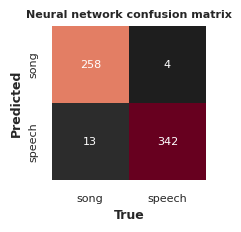

In [41]:
plot_cfm(y_test, y_pred_test, title="Neural network confusion matrix", cmap=CMAP_CFM)

In [42]:
net.model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                2320      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,551
Trainable params: 2,551
Non-trainable params: 0
_________________________________________________________________


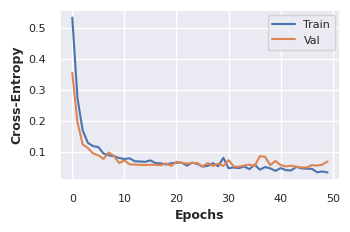

In [43]:
history = net.history_
plt.plot(history['loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

200/200 [==============================] - 1s 3ms/step


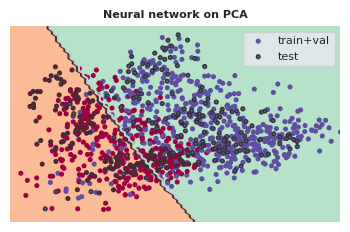

In [44]:
boundaries_on_embedding(reducer, net, embedding=embedding, 
                        n_pts=N_PTS,
                       cmap=CMAP,
                       title=f"Neural network on {embedding_name}")

# Ensemble methods

## Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [46]:
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 200, 2000, 10)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',['auto', 'sqrt'])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
#     epochs = trial.suggest_int('epochs', 10, 200,10)
    par = {'n_features_in_': 231, 'n_classes_': 2}                                      
                                          
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               bootstrap=bootstrap, criterion=criterion)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    error = accuracy_score(y_val, y_pred)

    return error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 50, n_jobs = -1, catch=(ValueError,))

[I 2023-07-10 15:31:22,777] A new study created in memory with name: no-name-6c91aef4-7a4f-40d6-9ce2-0d3e230a2da2
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
[W 2023-07-10 15:31:22,818] Trial 2 failed with parameters: {'n_estimators': 1030, 'max_depth': 0, 'max_

[W 2023-07-10 15:35:21,119] Trial 15 failed with value None.
[W 2023-07-10 15:35:21,279] Trial 16 failed with parameters: {'n_estimators': 1990, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-p

[W 2023-07-10 15:35:22,068] Trial 21 failed with value None.
[W 2023-07-10 15:35:22,217] Trial 22 failed with parameters: {'n_estimators': 1970, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-p

[W 2023-07-10 15:35:23,045] Trial 27 failed with value None.
[W 2023-07-10 15:35:23,170] Trial 28 failed with parameters: {'n_estimators': 1910, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-pa

[W 2023-07-10 15:35:24,035] Trial 33 failed with value None.
[W 2023-07-10 15:35:24,172] Trial 34 failed with parameters: {'n_estimators': 1910, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-p

[W 2023-07-10 15:35:24,894] Trial 39 failed with value None.
[W 2023-07-10 15:35:25,058] Trial 40 failed with parameters: {'n_estimators': 2000, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-p

[W 2023-07-10 15:35:25,841] Trial 45 failed with value None.
[W 2023-07-10 15:35:26,037] Trial 46 failed with parameters: {'n_estimators': 1740, 'max_depth': 0, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': False, 'criterion': 'gini'} because of the following error: InvalidParameterError("The 'max_depth' parameter of RandomForestClassifier must be an int in the range [1, inf) or None. Got 0 instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/3682342589.py", line 16, in objective_fun
    rf.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-pa

In [47]:
best_params = study.best_params

rf = RandomForestClassifier(**best_params)
rf.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = rf.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 1220, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 2, 'bootstrap': False, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       262
           1       1.00      0.95      0.97       355

    accuracy                           0.97       617
   macro avg       0.97      0.97      0.97       617
weighted avg       0.97      0.97      0.97       617

Accuracy 0.9708265802269044
F1-score [0.96666667 0.9740634 ]


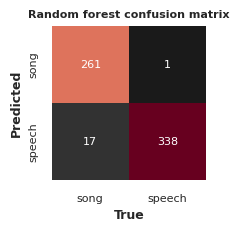

In [48]:
plot_cfm(y_test, y_pred_test, title="Random forest confusion matrix", cmap=CMAP_CFM)

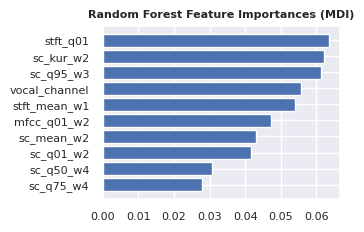

In [49]:
nbr_features = X_train.shape[1]

tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()[::-1][:10]
df2 = df.iloc[:, sorted_idx]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx][::-1])
plt.yticks(y_ticks, list(df2.columns)[::-1])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()

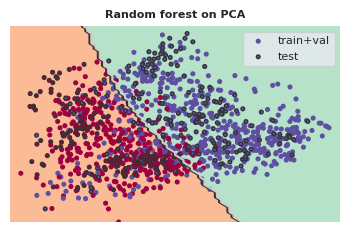

In [50]:
boundaries_on_embedding(reducer, rf, embedding=embedding,
                       cmap=CMAP,
                       n_pts=N_PTS,
                        title=f"Random forest on {embedding_name}")

In [51]:
from sklearn.inspection import permutation_importance

In [52]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

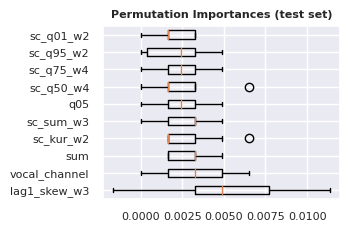

In [53]:
sorted_idx = result.importances_mean.argsort()[::-1][:10]
df2 = df.iloc[:, sorted_idx]

fig, ax = plt.subplots()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=list(df2.columns)[::-1])
plt.title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()

In [54]:
from sklearn.tree import plot_tree

In [55]:
rf.estimators_[0]

DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=11, random_state=1765087953)

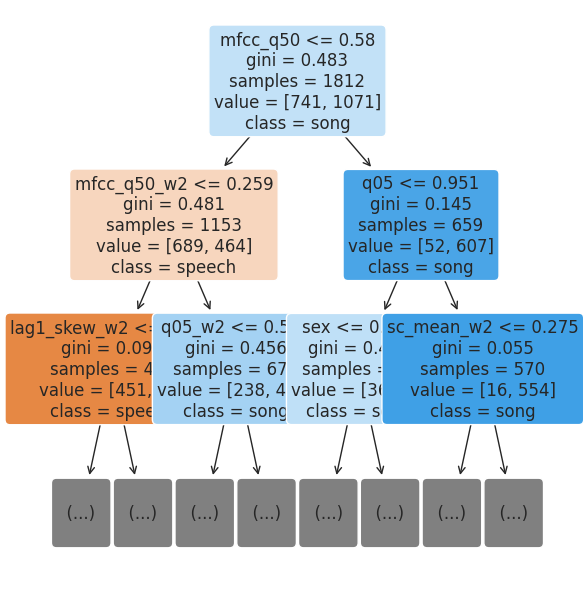

In [56]:
plt.figure(figsize=(6,6))
plot_tree(rf.estimators_[0], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

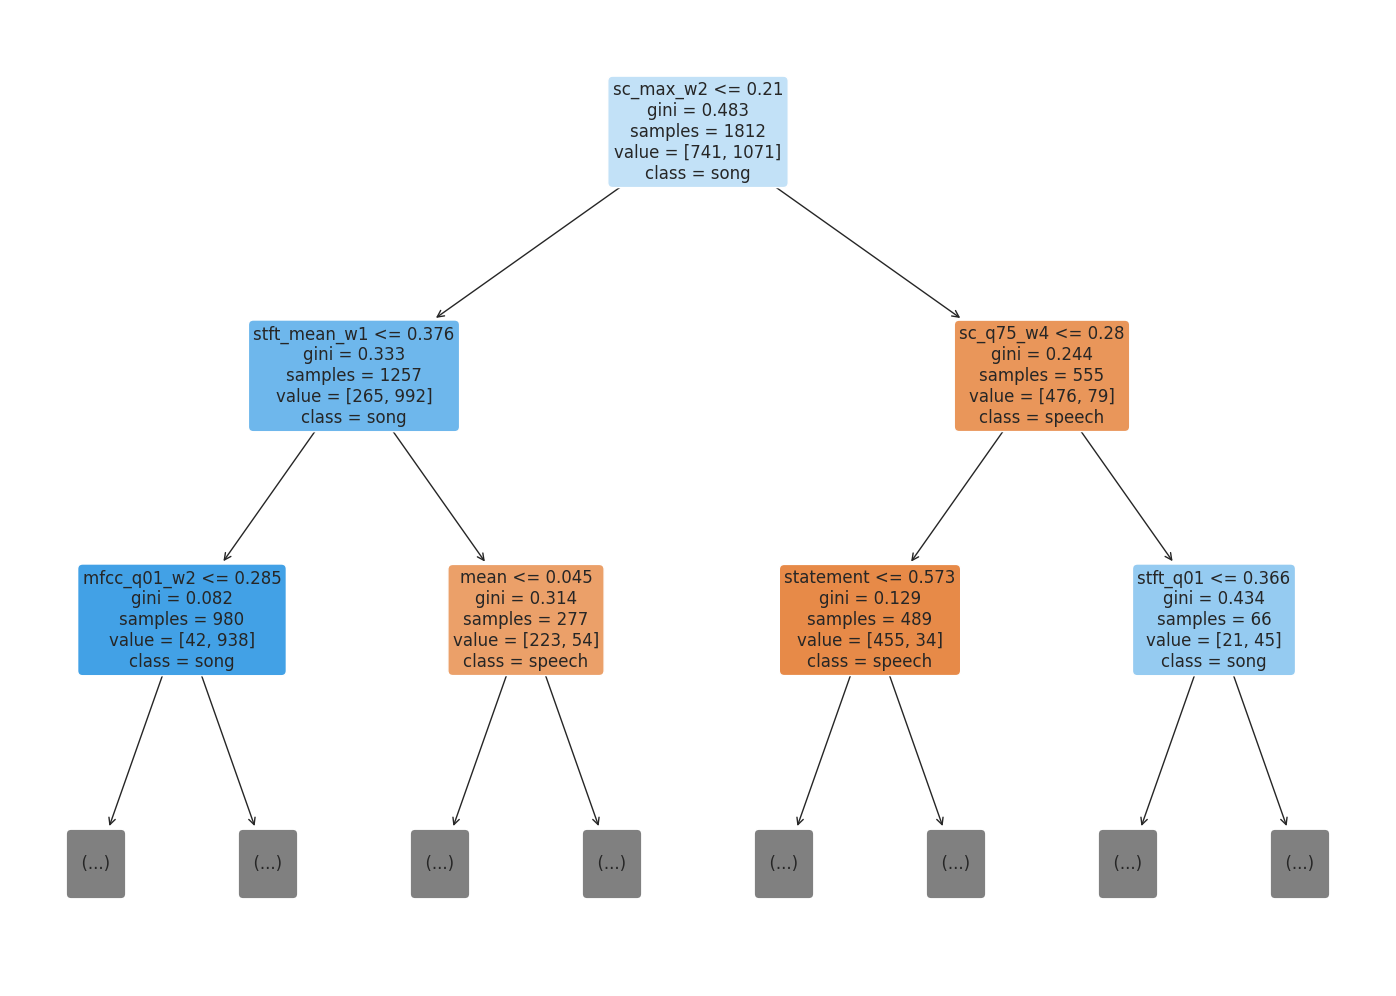

In [57]:
plt.figure(figsize=(14,10))
plot_tree(rf.estimators_[1], 
          feature_names=df.columns, 
          class_names=['speech', 'song'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

# Gradient Boosting

In [58]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

In [59]:
from sklearn.metrics import class_likelihood_ratios
def objective_fun(trial):
    
    n_estimators = trial.suggest_int('n_estimators', 1, 20)
    max_depth = trial.suggest_int('max_depth', 0, 100, 10)
    max_features = trial.suggest_categorical('max_features',["log2","sqrt"])
    min_samples_split = trial.suggest_int('min_samples_split', 1, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    criterion = trial.suggest_categorical('criterion', ["friedman_mse",  "mae"])
    subsample = trial.suggest_float('subsample', 0.5, 1)
    loss = trial.suggest_categorical('loss',['log_loss', 'deviance', 'exponential'])
                                  
                                          
    gb = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth , max_features=max_features, \
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, \
                               learning_rate=learning_rate, criterion=criterion, subsample=subsample, loss=loss)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_val)
    error = accuracy_score(y_val, y_pred)
    L_pos, L_neg = class_likelihood_ratios(y_val, y_pred)

    return L_pos#error


study = optuna.create_study(direction = 'maximize')
study.optimize(objective_fun, n_trials = 200, n_jobs = -1, catch=(ValueError,))

[I 2023-07-10 15:47:03,064] A new study created in memory with name: no-name-2b6ebade-8868-4dc1-988c-dd15f10a5a57
[W 2023-07-10 15:47:03,075] Trial 0 failed with parameters: {'n_estimators': 4, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 6, 'learning_rate': 0.22448329044638296, 'criterion': 'mae', 'subsample': 0.9570585514438168, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble

[W 2023-07-10 15:47:03,564] Trial 9 failed with value None.
[I 2023-07-10 15:47:03,735] Trial 2 finished with value: 31.176470588235293 and parameters: {'n_estimators': 6, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 4, 'learning_rate': 0.2982419666751659, 'criterion': 'friedman_mse', 'subsample': 0.9421387763788529, 'loss': 'deviance'}. Best is trial 3 with value: 51.96078431372549.
[I 2023-07-10 15:47:04,326] Trial 7 finished with value: 52.48039215686274 and parameters: {'n_estimators': 20, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 1, 'learning_rate': 0.12231365364313755, 'criterion': 'friedman_mse', 'subsample': 0.7561012414605301, 'loss': 'deviance'}. Best is trial 7 with value: 52.48039215686274.
[W 2023-07-10 15:47:04,339] Trial 12 failed with parameters: {'n_estimators': 8, 'max_depth': 50, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 9, 'learning_rate': 0.015095185924879

[W 2023-07-10 15:47:04,952] Trial 19 failed with value None.
[W 2023-07-10 15:47:04,965] Trial 20 failed with parameters: {'n_estimators': 12, 'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 3, 'learning_rate': 0.2400271817650442, 'criterion': 'mae', 'subsample': 0.911609961994238, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-10 15:47:05,342] Trial 26 failed with parameters: {'n_estimators': 20, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.014320576862824591, 'criterion': 'mae', 'subsample': 0.6958922524419391, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/l

[W 2023-07-10 15:47:05,790] Trial 31 failed with value None.
[W 2023-07-10 15:47:05,874] Trial 32 failed with parameters: {'n_estimators': 20, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.018077760305403548, 'criterion': 'mae', 'subsample': 0.6976120328409804, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-10 15:47:06,391] Trial 37 failed with value None.
[W 2023-07-10 15:47:06,491] Trial 38 failed with parameters: {'n_estimators': 20, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.020686855736343462, 'criterion': 'mae', 'subsample': 0.6852082011124752, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-10 15:47:06,888] Trial 43 failed with value None.
[W 2023-07-10 15:47:06,963] Trial 44 failed with parameters: {'n_estimators': 20, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.018742870992261518, 'criterion': 'mae', 'subsample': 0.6903736260524221, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()


[W 2023-07-10 15:47:07,400] Trial 48 failed with parameters: {'n_estimators': 20, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 1, 'learning_rate': 0.18451115014046807, 'criterion': 'mae', 'subsample': 0.6744758170215757, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmf

[W 2023-07-10 15:47:07,867] Trial 54 failed with value None.
[W 2023-07-10 15:47:07,934] Trial 55 failed with parameters: {'n_estimators': 19, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 1, 'learning_rate': 0.1830569167682318, 'criterion': 'mae', 'subsample': 0.6927723971139756, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-10 15:47:08,238] Trial 60 failed with value None.
[W 2023-07-10 15:47:08,235] Trial 59 failed with value None.
[W 2023-07-10 15:47:08,232] Trial 58 failed with value None.
[W 2023-07-10 15:47:08,436] Trial 63 failed with parameters: {'n_estimators': 20, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 1, 'learning_rate': 0.1832954700953794, 'criterion': 'mae', 'subsample': 0.6932217620886825, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/vi

[W 2023-07-10 15:47:08,833] Trial 66 failed with parameters: {'n_estimators': 20, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 1, 'learning_rate': 0.18322997665472732, 'criterion': 'mae', 'subsample': 0.6870899968667887, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa

[W 2023-07-10 15:47:09,182] Trial 71 failed with value None.
[W 2023-07-10 15:47:09,210] Trial 72 failed with value None.
[W 2023-07-10 15:47:09,266] Trial 73 failed with parameters: {'n_estimators': 20, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.18450526812195867, 'criterion': 'mae', 'subsample': 0.5053928283288197, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/

[W 2023-07-10 15:47:09,656] Trial 78 failed with value None.
[I 2023-07-10 15:47:09,666] Trial 17 finished with value: 78.33088235294117 and parameters: {'n_estimators': 16, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 8, 'learning_rate': 0.2779196658535829, 'criterion': 'friedman_mse', 'subsample': 0.6724769475245447, 'loss': 'log_loss'}. Best is trial 17 with value: 78.33088235294117.
[W 2023-07-10 15:47:09,707] Trial 77 failed with value None.
[W 2023-07-10 15:47:09,723] Trial 79 failed with parameters: {'n_estimators': 20, 'max_depth': 0, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 1, 'learning_rate': 0.1848665880155358, 'criterion': 'mae', 'subsample': 0.6859040057621745, 'loss': 'exponential'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  Fi

[W 2023-07-10 15:47:10,041] Trial 82 failed with value None.
[W 2023-07-10 15:47:10,140] Trial 84 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.011716623370467319, 'criterion': 'mae', 'subsample': 0.6836451893906667, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-10 15:47:10,460] Trial 87 failed with value None.
[W 2023-07-10 15:47:10,482] Trial 88 failed with value None.
[W 2023-07-10 15:47:10,532] Trial 89 failed with value None.
[W 2023-07-10 15:47:10,534] Trial 90 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.18720258378720697, 'criterion': 'mae', 'subsample': 0.7163384417903123, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/vir

[W 2023-07-10 15:47:11,058] Trial 95 failed with parameters: {'n_estimators': 18, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.18051791354372168, 'criterion': 'mae', 'subsample': 0.6956386904784545, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/l

[W 2023-07-10 15:47:11,445] Trial 102 failed with parameters: {'n_estimators': 20, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.012164156310802296, 'criterion': 'mae', 'subsample': 0.7108216189290542, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/

[W 2023-07-10 15:47:11,939] Trial 107 failed with value None.
[W 2023-07-10 15:47:11,984] Trial 109 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 1, 'learning_rate': 0.1881534622094007, 'criterion': 'mae', 'subsample': 0.6958250475603103, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-10 15:47:12,313] Trial 112 failed with value None.
[W 2023-07-10 15:47:12,344] Trial 113 failed with value None.
[W 2023-07-10 15:47:12,422] Trial 114 failed with parameters: {'n_estimators': 20, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.19574552799227585, 'criterion': 'mae', 'subsample': 0.6914739393537604, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/

[W 2023-07-10 15:47:12,928] Trial 118 failed with value None.
[W 2023-07-10 15:47:12,928] Trial 120 failed with parameters: {'n_estimators': 20, 'max_depth': 0, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 1, 'learning_rate': 0.012145551599966387, 'criterion': 'mae', 'subsample': 0.6941358682562198, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-10 15:47:13,337] Trial 125 failed with value None.
[W 2023-07-10 15:47:13,465] Trial 127 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.2955671281137616, 'criterion': 'mae', 'subsample': 0.6851387761410708, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-10 15:47:13,841] Trial 132 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.1866292471704507, 'criterion': 'mae', 'subsample': 0.6927036572704004, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/l

[W 2023-07-10 15:47:14,198] Trial 136 failed with value None.
[W 2023-07-10 15:47:14,314] Trial 137 failed with value None.
[W 2023-07-10 15:47:14,327] Trial 139 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.18318336786884398, 'criterion': 'mae', 'subsample': 0.6905911986355071, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn

[W 2023-07-10 15:47:14,710] Trial 143 failed with value None.
[W 2023-07-10 15:47:14,735] Trial 145 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 1, 'learning_rate': 0.011463451305903344, 'criterion': 'mae', 'subsample': 0.7166124146202552, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params

[W 2023-07-10 15:47:15,072] Trial 148 failed with value None.
[W 2023-07-10 15:47:15,159] Trial 149 failed with value None.
[W 2023-07-10 15:47:15,172] Trial 151 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.19042098573056387, 'criterion': 'mae', 'subsample': 0.7186871771159019, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn

[W 2023-07-10 15:47:15,514] Trial 154 failed with value None.
[W 2023-07-10 15:47:15,527] Trial 156 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'learning_rate': 0.1847232990860019, 'criterion': 'mae', 'subsample': 0.7096062674385002, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-10 15:47:15,905] Trial 160 failed with value None.
[W 2023-07-10 15:47:15,951] Trial 162 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 1, 'learning_rate': 0.29927887260216773, 'criterion': 'mae', 'subsample': 0.7006466104836265, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-10 15:47:16,333] Trial 166 failed with value None.
[W 2023-07-10 15:47:16,400] Trial 168 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.17874702084290678, 'criterion': 'mae', 'subsample': 0.7051880803316015, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-10 15:47:16,743] Trial 171 failed with value None.
[W 2023-07-10 15:47:16,745] Trial 173 failed with value None.
[W 2023-07-10 15:47:16,767] Trial 172 failed with value None.
[W 2023-07-10 15:47:16,842] Trial 174 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.18014327454856408, 'criterion': 'mae', 'subsample': 0.6835118733492769, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share

[W 2023-07-10 15:47:17,223] Trial 178 failed with value None.
[W 2023-07-10 15:47:17,236] Trial 180 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.2976085067274308, 'criterion': 'mae', 'subsample': 0.6892865602899589, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()

[W 2023-07-10 15:47:17,600] Trial 184 failed with value None.
[W 2023-07-10 15:47:17,699] Trial 185 failed with value None.
[W 2023-07-10 15:47:17,715] Trial 186 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 1, 'learning_rate': 0.197877790518936, 'criterion': 'mae', 'subsample': 0.7000550018224461, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/e

[W 2023-07-10 15:47:18,040] Trial 190 failed with value None.
[W 2023-07-10 15:47:18,064] Trial 192 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.18937531934883545, 'criterion': 'mae', 'subsample': 0.6919762002343877, 'loss': 'deviance'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params(

[W 2023-07-10 15:47:18,414] Trial 195 failed with value None.
[W 2023-07-10 15:47:18,415] Trial 196 failed with value None.
[W 2023-07-10 15:47:18,474] Trial 197 failed with value None.
[W 2023-07-10 15:47:18,486] Trial 198 failed with parameters: {'n_estimators': 20, 'max_depth': 60, 'max_features': 'sqrt', 'min_samples_split': 1, 'min_samples_leaf': 1, 'learning_rate': 0.19061443043894727, 'criterion': 'mae', 'subsample': 0.6960457897838873, 'loss': 'log_loss'} because of the following error: InvalidParameterError("The 'criterion' parameter of GradientBoostingClassifier must be a str among {'friedman_mse', 'squared_error'}. Got 'mae' instead.").
Traceback (most recent call last):
  File "/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_29070/1772591644.py", line 18, in objective_fun
    gb.fit(X_train, y_train)
  File "/home/djanloo/.local/share

In [60]:
best_params = study.best_params

gb = GradientBoostingClassifier(**best_params)
gb.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

y_pred_test = gb.predict(X_test)


from sklearn.metrics import classification_report

print(best_params)


print(classification_report(y_test, y_pred_test))
print('Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('F1-score %s' % f1_score(y_test, y_pred_test, average=None))

{'n_estimators': 16, 'max_depth': 90, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 8, 'learning_rate': 0.2779196658535829, 'criterion': 'friedman_mse', 'subsample': 0.6724769475245447, 'loss': 'log_loss'}
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       262
           1       0.99      0.93      0.96       355

    accuracy                           0.96       617
   macro avg       0.95      0.96      0.96       617
weighted avg       0.96      0.96      0.96       617

Accuracy 0.9578606158833063
F1-score [0.95238095 0.9622093 ]


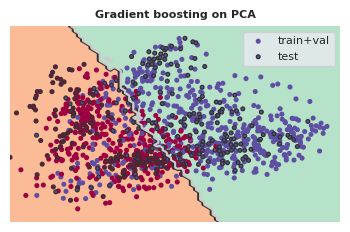

In [61]:
boundaries_on_embedding(reducer, gb, embedding=embedding,
                       cmap=CMAP,
                       n_pts=N_PTS,
                       title=f"Gradient boosting on {embedding_name}")

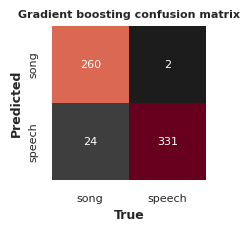

In [62]:
plot_cfm(y_test, y_pred_test, title="Gradient boosting confusion matrix", cmap=CMAP_CFM)

In [70]:
(df.vocal_channel =="song").sum()/len(df)*100

41.29271305063813